<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Removing-duplicate-tweets" data-toc-modified-id="Removing-duplicate-tweets-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Removing duplicate tweets</a></span></li></ul></li><li><span><a href="#Lemmatization-with-SpaCy" data-toc-modified-id="Lemmatization-with-SpaCy-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Lemmatization with SpaCy</a></span></li><li><span><a href="#Count-vectorization-with-TF-IDF" data-toc-modified-id="Count-vectorization-with-TF-IDF-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Count vectorization with TF-IDF</a></span></li><li><span><a href="#Dimensionality-Reduction" data-toc-modified-id="Dimensionality-Reduction-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Dimensionality Reduction</a></span><ul class="toc-item"><li><span><a href="#PCA-/-SVD" data-toc-modified-id="PCA-/-SVD-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>PCA / SVD</a></span></li><li><span><a href="#NMF" data-toc-modified-id="NMF-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>NMF</a></span></li><li><span><a href="#LDA-(??)" data-toc-modified-id="LDA-(??)-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>LDA (??)</a></span></li><li><span><a href="#CorEx-Model---11-Topics" data-toc-modified-id="CorEx-Model---11-Topics-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>CorEx Model - 11 Topics</a></span></li><li><span><a href="#CorEx-Model-FINAL---10-Topics" data-toc-modified-id="CorEx-Model-FINAL---10-Topics-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>CorEx Model FINAL - 10 Topics</a></span></li><li><span><a href="#CorEx-Model---13-Topics" data-toc-modified-id="CorEx-Model---13-Topics-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>CorEx Model - 13 Topics</a></span></li></ul></li><li><span><a href="#Sentiment-Analysis" data-toc-modified-id="Sentiment-Analysis-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Sentiment Analysis</a></span><ul class="toc-item"><li><span><a href="#Overlaying-Sentiment-and-Topic-Analysis" data-toc-modified-id="Overlaying-Sentiment-and-Topic-Analysis-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Overlaying Sentiment and Topic Analysis</a></span></li></ul></li><li><span><a href="#Exploring-topics-v-companies" data-toc-modified-id="Exploring-topics-v-companies-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Exploring topics v companies</a></span></li><li><span><a href="#Word-Clouds" data-toc-modified-id="Word-Clouds-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Word Clouds</a></span></li><li><span><a href="#ScatterText" data-toc-modified-id="ScatterText-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>ScatterText</a></span></li><li><span><a href="#Clustering-Analysis---DBSCAN" data-toc-modified-id="Clustering-Analysis---DBSCAN-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Clustering Analysis - DBSCAN</a></span></li></ul></div>

In [243]:
import pickle
from IPython import display
from tqdm import tqdm
import time
import os
import copy
from langdetect import detect
from requests.exceptions import Timeout, ConnectionError
from requests.packages.urllib3.exceptions import ReadTimeoutError
from ssl import SSLError
import re
import numpy as np
import pandas as pd

import spacy
from spacy.attrs import *
from spacy.lemmatizer import Lemmatizer
from spacy.lang.en import LEMMA_INDEX, LEMMA_EXC, LEMMA_RULES

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction import text
from nltk.tokenize import word_tokenize
import nltk
from nltk.corpus import stopwords
# nltk.download('punkt')
# nltk.download('stopwords')
import string

from sklearn.decomposition import PCA, NMF

from corextopic import corextopic as ct
from corextopic import vis_topic as vt
import scipy.sparse as ss

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob 

import matplotlib.pyplot as plt
import seaborn as sns

In [244]:
%matplotlib inline
sns.set()

In [245]:
def clean_tweets(x):
    try:
        if (re.search('[A-Za-z]+', x)) and (detect(x) == 'en'):
            return re.sub('@[\w\d\S]+|https?:\/\/[^\s]*|(\\n)+|#[\w\d]+|&amp;|[\/]+', ' ', x)
        else:
            return np.nan
    except:
        return np.nan

In [246]:
def count_unique_tweets(x):
    return len(set(x))

In [247]:
def update_tweet_count(x, other_df):
    try:
        count = int(other_df[other_df['user']==x]['size'].mean())
    except:
        count = 0
    return count

In [248]:
def tweet_class(x):
    if re.match('[\d]+', x):
        return 'user'
    else:
        return 'company'

In [7]:
df = pd.read_csv('https://storage.googleapis.com/kaggle-data-sets/4133/8841/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1569363982&Signature=l55H2DK%2F4WP0pa%2F4TkteF8hTJdl3RDZjaD%2BkEJpThl99%2BmvTzj4vTj637DoCk3tPmMYAuCJlowd2RpVnYZiVxGop39g5gwey%2BC9b%2FhIZ1KpczfnCjmQOWvi3LninuPChO%2FBuE%2BF2bv9qEev6TO%2BUZlRNPNbfrRZ48yVhqhP41Ur64QXw2vU%2FyVNr6EmlJLQaV0XsdnzwpEcqHU5gd2bPk3Txn8lNRUk4X%2FhIcOOHtsYjLQvfdEftUZhdrru7R9if10JUAKiKlUOC3QR%2FGLWA%2FxQTkU%2Bi4BqiVYtQEsYQJUKrHnPHCXLeiwdAiVZz9EBxtaFmZzUpqe%2FxlabxC608vw%3D%3D&response-content-disposition=attachment%3B+filename%3Dcustomer-support-on-twitter.zip')

KeyboardInterrupt: 

In [ ]:
df.info()

In [7]:
tqdm.pandas()

In [11]:
df['from'] = df['author_id'].progress_apply(tweet_class)

100%|██████████| 2811774/2811774 [00:06<00:00, 422808.46it/s]


In [ ]:
df.head()

In [248]:
first_inbound = df[pd.isnull(df.in_response_to_tweet_id) & df.inbound]

QnR = pd.merge(first_inbound, df, left_on='tweet_id', 
                                  right_on='in_response_to_tweet_id')

# Filter to only outbound replies (from companies)
QnR = QnR[QnR.inbound_y ^ True]
print(f'Data shape: {QnR.shape}')

QnR.head()

Data shape: (794299, 16)


,tweet_id_x,author_id_x,inbound_x,created_at_x,text_x,response_tweet_id_x,in_response_to_tweet_id_x,from_x,tweet_id_y,author_id_y,inbound_y,created_at_y,text_y,response_tweet_id_y,in_response_to_tweet_id_y,from_y
0,8,115712,True,Tue Oct 31 21:45:10 +0000 2017,@sprintcare is the worst customer service,"9,6,10",NaN,user,6,sprintcare,False,Tue Oct 31 21:46:24 +0000 2017,@115712 Can you please send us a private messa...,"5,7",8.0,company
1,8,115712,True,Tue Oct 31 21:45:10 +0000 2017,@sprintcare is the worst customer service,"9,6,10",NaN,user,9,sprintcare,False,Tue Oct 31 21:46:14 +0000 2017,@115712 I would love the chance to review the ...,NaN,8.0,company
2,8,115712,True,Tue Oct 31 21:45:10 +0000 2017,@sprintcare is the worst customer service,"9,6,10",NaN,user,10,sprintcare,False,Tue Oct 31 21:45:59 +0000 2017,@115712 Hello! We never like our customers to ...,NaN,8.0,company
3,18,115713,True,Tue Oct 31 19:56:01 +0000 2017,@115714 y’all lie about your “great” connectio...,17,NaN,user,17,sprintcare,False,Tue Oct 31 19:59:13 +0000 2017,@115713 H there! We'd definitely like to work ...,16,18.0,company
4,20,115715,True,Tue Oct 31 22:03:34 +0000 2017,"@115714 whenever I contact customer support, t...",19,NaN,user,19,sprintcare,False,Tue Oct 31 22:10:10 +0000 2017,@115715 Please send me a private message so th...,NaN,20.0,company


In [ ]:
original_df = copy.deepcopy(df)

In [256]:
df_customers1 = df[df['from'] == 'user']
df_customers1.reset_index(drop=True, inplace=True)

In [259]:
df_customers2 = QnR[QnR['from_x'] == 'user']
df_customers2.reset_index(drop=True, inplace=True)

In [ ]:
# df['text'] = df['text'].progress_apply(clean_tweets)

In [ ]:
df_customers_subset = df_customers.iloc[:500000, :]
df_customers_subset['text'] = df_customers_subset['text'].progress_apply(clean_tweets)
df_customers_subset['text'] = df_customers_subset['text'].astype('str') 

In [9]:
def get_at(x):
    if re.search('(@[A-Za-z]+)(\s.+)', x):
        return re.search('(@[A-Za-z]+)(\s.+)', x).group(1)
    else:
        return np.nan

In [257]:
df_customers_subset_raw1 = copy.deepcopy(df_customers1)

In [260]:
df_customers_subset_raw2 = copy.deepcopy(df_customers2)

In [240]:
df_customers_subset_raw.columns

Index(['tweet_id_x', 'author_id_x', 'inbound_x', 'created_at_x', 'text_x',
       'response_tweet_id_x', 'in_response_to_tweet_id_x', 'from_x',
       'tweet_id_y', 'author_id_y', 'inbound_y', 'created_at_y', 'text_y',
       'response_tweet_id_y', 'in_response_to_tweet_id_y', 'from_y'],
      dtype='object')

In [261]:
del df_customers_subset_raw2['tweet_id_y']
del df_customers_subset_raw2['inbound_y']
del df_customers_subset_raw2['created_at_y']
del df_customers_subset_raw2['text_y']
del df_customers_subset_raw2['response_tweet_id_y']
del df_customers_subset_raw2['in_response_to_tweet_id_y']
del df_customers_subset_raw2['from_y']

In [262]:
df_customers_subset_raw1.columns

Index(['tweet_id', 'author_id', 'inbound', 'created_at', 'text',
       'response_tweet_id', 'in_response_to_tweet_id', 'from'],
      dtype='object')

In [263]:
df_customers_subset_raw2.columns = ['tweet_id', 'author_id', 'inbound', 'created_at', 'text', 'response_tweet_id', 'in_response_to_tweet_id', 'from', '@']

In [264]:
df_customers_subset_raw2.columns

Index(['tweet_id', 'author_id', 'inbound', 'created_at', 'text',
       'response_tweet_id', 'in_response_to_tweet_id', 'from', '@'],
      dtype='object')

In [245]:
df_customers_subset_raw.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,from,@
0,8,115712,True,Tue Oct 31 21:45:10 +0000 2017,@sprintcare is the worst customer service,"9,6,10",NaN,user,sprintcare
1,8,115712,True,Tue Oct 31 21:45:10 +0000 2017,@sprintcare is the worst customer service,"9,6,10",NaN,user,sprintcare
2,8,115712,True,Tue Oct 31 21:45:10 +0000 2017,@sprintcare is the worst customer service,"9,6,10",NaN,user,sprintcare
3,18,115713,True,Tue Oct 31 19:56:01 +0000 2017,@115714 y’all lie about your “great” connectio...,17,NaN,user,sprintcare
4,20,115715,True,Tue Oct 31 22:03:34 +0000 2017,"@115714 whenever I contact customer support, t...",19,NaN,user,sprintcare


In [268]:
df_customers_subset_raw1 = df_customers1.iloc[:500000, :]
df_customers_subset_raw1['@'] = df_customers_subset_raw1['text'].progress_apply(get_at)



  0%|          | 0/500000 [00:00<?, ?it/s]

  4%|▍         | 19160/500000 [00:00<00:02, 191596.07it/s]

  7%|▋         | 34594/500000 [00:00<00:02, 178655.15it/s]

  9%|▉         | 45027/500000 [00:00<00:03, 147195.51it/s]

 11%|█         | 54215/500000 [00:00<00:03, 123658.95it/s]

 13%|█▎        | 64331/500000 [00:00<00:03, 115812.37it/s]

 17%|█▋        | 86304/500000 [00:00<00:03, 134960.36it/s]

 21%|██        | 106002/500000 [00:00<00:02, 149036.83it/s]

 27%|██▋       | 133986/500000 [00:00<00:02, 173343.68it/s]

 32%|███▏      | 158169/500000 [00:00<00:01, 189436.94it/s]

 36%|███▌      | 178719/500000 [00:01<00:01, 168670.02it/s]

 39%|███▉      | 197133/500000 [00:01<00:01, 168596.29it/s]

 44%|████▍     | 219723/500000 [00:01<00:01, 182483.31it/s]

 48%|████▊     | 239060/500000 [00:01<00:01, 172779.83it/s]

 52%|█████▏    | 258155/500000 [00:01<00:01, 177856.10it/s]

 57%|█████▋    | 285580/500000 [00:01<00:01, 198819.77it/s]

 62%|██████▏   | 309120/500000 [00:01<00:00, 

In [225]:
# df_customers_subset_raw[@]

False

In [226]:
with open('data/cs/cust_subsets/customer_tweets_@_subset.pkl', 'wb') as f_write:
    pickle.dump(df_customers_subset_raw, f_write)

In [ ]:
with open('data/cs/customer_tweets_cleaned_subset.pkl', 'wb') as f_write:
    pickle.dump(df_customers_subset, f_write)

In [ ]:
# with open('data/cs/tweets_cleaned.pkl', 'wb') as f_write:
#     pickle.dump(df, f_write)

In [ ]:
with open('data/cs/customer_tweets_cleaned_subset.pkl', 'rb') as f_read:
    df_customers_subset = pickle.load(f_read)

In [ ]:
df_customers_subset['tweet_len'] = df_customers_subset['text'].progress_apply(len)

In [ ]:
df_minlen = df_customers_subset[df_customers_subset['tweet_len'] > 40]

In [ ]:
df_minlen.info()

In [ ]:
with open('data/cs/long_tweets__cust_subset.pkl', 'wb') as f_write:
    pickle.dump(df_minlen, f_write)

In [ ]:
with open('data/cs/long_tweets_cust_subset.pkl', 'rb') as f_read:
    df_minlen = pickle.load(f_read)

In [ ]:
# user_corpus[-1]['tweets']

## Removing duplicate tweets

In [ ]:
df_minlen.head()

In [ ]:
df_minlen_nodupes = df_minlen.drop_duplicates(subset=['author_id', 'text'], keep='first')
df_minlen_nodupes.reset_index(drop=True, inplace=True)

In [ ]:
with open('data/cs/long_cust_tweets_subset_dedup.pkl', 'wb') as f_write:
    pickle.dump(df_minlen_nodupes, f_write)

In [ ]:
df_minlen_nodupes.info()

# Lemmatization with SpaCy

In [ ]:
with open('data/cs/long_cust_tweets_subset_dedup.pkl', 'rb') as f_read:
    df_minlen_nodupes = pickle.load(f_read)

In [ ]:
# df_minlen_nodupes.sample(20)

In [ ]:
def lowercase(x):
    return x.lower()

In [ ]:
def lemmatize(x):
    doc = nlp(x)
    return " ".join([token.lemma_ if token.lemma_ != '-PRON-' else '' for token in doc])

In [ ]:
nlp = spacy.load('en', disable=['parser'])

nlp.tokenizer.add_special_case("tweet", [{ORTH: u'tweet', LEMMA: u'twitter', POS: u'NOUN'}])
nlp.tokenizer.add_special_case("twitt", [{ORTH: u'twitt', LEMMA: u'twitter', POS: u'NOUN'}])
nlp.tokenizer.add_special_case("truly", [{ORTH: u'truly', LEMMA: u'true', POS: u'ADV'}])
nlp.tokenizer.add_special_case("usually", [{ORTH: u'usually', LEMMA: u'usual', POS: u'ADV'}])
nlp.tokenizer.add_special_case("vibes", [{ORTH: u'vibes', LEMMA: u'vibe', POS: u'NOUN'}])
nlp.tokenizer.add_special_case("teacher", [{ORTH: u'teacher', LEMMA: u'teach', POS: u'NOUN'}])
nlp.tokenizer.add_special_case("therpist", [{ORTH: u'therapist', LEMMA: u'therapy', POS: u'NOUN'}])
nlp.tokenizer.add_special_case("threaten", [{ORTH: u'threaten', LEMMA: u'threat', POS: u'VB'}])
nlp.tokenizer.add_special_case("til", [{ORTH: u'til', LEMMA: u'till', POS: u'NOUN'}])
nlp.tokenizer.add_special_case("spiritual", [{ORTH: u'spiritual', LEMMA: u'spirit', POS: u'ADV'}])
nlp.tokenizer.add_special_case("standing", [{ORTH: u'standing', LEMMA: u'stand', POS: u'VB'}])
nlp.tokenizer.add_special_case("states", [{ORTH: u'states', LEMMA: u'state', POS: u'NOUN'}])
nlp.tokenizer.add_special_case("strong", [{ORTH: u'strong', LEMMA: u'strength', POS: u'ADJ'}])
nlp.tokenizer.add_special_case("student", [{ORTH: u'student', LEMMA: u'study', POS: u'NOUN'}])
nlp.tokenizer.add_special_case("successful", [{ORTH: u'successful', LEMMA: u'success', POS: u'ADV'}])
nlp.tokenizer.add_special_case("suddenly", [{ORTH: u'suddenly', LEMMA: u'sudden', POS: u'ADV'}])
nlp.tokenizer.add_special_case("sunny", [{ORTH: u'sunny', LEMMA: u'sun', POS: u'ADJ'}])
nlp.tokenizer.add_special_case("supporter", [{ORTH: u'supporter', LEMMA: u'support', POS: u'NOUN'}])
nlp.tokenizer.add_special_case("surprised", [{ORTH: u'surprised', LEMMA: u'surprise', POS: u'VB'}])
nlp.tokenizer.add_special_case("surprising", [{ORTH: u'surprising', LEMMA: u'surprise', POS: u'ADJ'}])
nlp.tokenizer.add_special_case("shitty", [{ORTH: u'shitty', LEMMA: u'shit', POS: u'ADJ'}])
nlp.tokenizer.add_special_case("shooting", [{ORTH: u'shooting', LEMMA: u'shoot', POS: u'NOUN'}])
nlp.tokenizer.add_special_case("shooting", [{ORTH: u'shooting', LEMMA: u'shoot', POS: u'VB'}])
nlp.tokenizer.add_special_case("shopping", [{ORTH: u'shopping', LEMMA: u'shop', POS: u'VB'}])
nlp.tokenizer.add_special_case("silent", [{ORTH: u'silent', LEMMA: u'silence', POS: u'ADJ'}])
nlp.tokenizer.add_special_case("simply", [{ORTH: u'simply', LEMMA: u'simple', POS: u'ADV'}])
nlp.tokenizer.add_special_case("singing", [{ORTH: u'singing', LEMMA: u'sing', POS: u'VB'}])
nlp.tokenizer.add_special_case("sis", [{ORTH: u'sis', LEMMA: u'sister', POS: u'NOUN'}])
nlp.tokenizer.add_special_case("slowly", [{ORTH: u'slowly', LEMMA: u'slow', POS: u'ADV'}])
nlp.tokenizer.add_special_case("soften", [{ORTH: u'soften', LEMMA: u'soft', POS: u'VB'}])
nlp.tokenizer.add_special_case("smoking", [{ORTH: u'smoking', LEMMA: u'smoke', POS: u'VB'}])
nlp.tokenizer.add_special_case("speaker", [{ORTH: u'speaker', LEMMA: u'speak', POS: u'NOUN'}])
nlp.tokenizer.add_special_case("speech", [{ORTH: u'speech', LEMMA: u'speak', POS: u'NOUN'}])
nlp.tokenizer.add_special_case("specifically", [{ORTH: u'specifically', LEMMA: u'specific', POS: u'ADV'}])
nlp.tokenizer.add_special_case("serve", [{ORTH: u'serve', LEMMA: u'service', POS: u'NOUN'}])
nlp.tokenizer.add_special_case("texte", [{ORTH: u'texte', LEMMA: u'text', POS: u'NOUN'}])
nlp.tokenizer.add_special_case("bro", [{ORTH: u'bro', LEMMA: u'brother', POS: u'NOUN'}])
nlp.tokenizer.add_special_case("bday", [{ORTH: u'bday', LEMMA: u'birthday', POS: u'NOUN'}])
nlp.tokenizer.add_special_case("ppl", [{ORTH: u'ppl', LEMMA: u'people', POS: u'NOUN'}])
nlp.tokenizer.add_special_case("absolutely", [{ORTH: u'absolutely', LEMMA: u'absolute', POS: u'ADV'}])
nlp.tokenizer.add_special_case("acceptable", [{ORTH: u'acceptable', LEMMA: u'accept', POS: u'ADJ'}])
nlp.tokenizer.add_special_case("accounts", [{ORTH: u'accounts', LEMMA: u'account', POS: u'NOUN'}])
nlp.tokenizer.add_special_case("actually", [{ORTH: u'actually', LEMMA: u'actual', POS: u'ADV'}])
nlp.tokenizer.add_special_case("added", [{ORTH: u'added', LEMMA: u'add', POS: u'VB'}])
nlp.tokenizer.add_special_case("adding", [{ORTH: u'adding', LEMMA: u'add', POS: u'VB'}])
nlp.tokenizer.add_special_case("additional", [{ORTH: u'additional', LEMMA: u'add', POS: u'ADJ'}])
nlp.tokenizer.add_special_case("advise", [{ORTH: u'advise', LEMMA: u'advice', POS: u'VB'}])
nlp.tokenizer.add_special_case("advise", [{ORTH: u'advise', LEMMA: u'advice', POS: u'NOUN'}])
nlp.tokenizer.add_special_case("agents", [{ORTH: u'agents', LEMMA: u'agent', POS: u'NOUN'}])
nlp.tokenizer.add_special_case("airlines", [{ORTH: u'airlines', LEMMA: u'airline', POS: u'NOUN'}])
nlp.tokenizer.add_special_case("allowed", [{ORTH: u'allowed', LEMMA: u'allow', POS: u'VB'}])
nlp.tokenizer.add_special_case("american", [{ORTH: u'american', LEMMA: u'america', POS: u'ADJ'}])
nlp.tokenizer.add_special_case("answers", [{ORTH: u'answers', LEMMA: u'answer', POS: u'VB'}])

In [ ]:
# doc = nlp('it was the worst')
# print(" ".join([token.lemma_ if token.lemma_ != '-PRON-' else '' for token in doc]))
# # nlp("answers")[0].lemma_ == "true" 

In [ ]:
# nlp = spacy.load('en', disable=['parser'])
# doc = nlp('3:01 Am')

In [ ]:
# # Up To 13000 rows!
# for idx, row in df_minlen_nodupes.iterrows():
#     row['lemma_tweets'] = lemmatize(row['text'])
#     display.clear_output(wait=True)
#     print('Row {} done'.format(idx))
#     with open('data/cs/lemma_cust_tweets_subset.pkl', 'wb') as f_write:
#         pickle.dump(df_minlen_nodupes, f_write)

In [ ]:
# with open('data/cs/lemma_customer_tweets_subset.pkl', 'rb') as f_read:
#     df_lem_nodupes = pickle.load(f_read)

In [ ]:
df_minlen_nodupes['lemma_tweets'] = df_minlen_nodupes['text'].progress_apply(lemmatize)
with open('data/cs/lemma_cust_tweets_subset.pkl', 'wb') as tweet_dump:
    pickle.dump(df_minlen_nodupes, tweet_dump)

In [ ]:
# with open('data/lemma_tweets_newest2.pkl', 'wb') as tweet_dump:
#     pickle.dump(df_minlen_nodupes, tweet_dump)

In [ ]:
df_minlen_nodupes.info()

# Count vectorization with TF-IDF

In [331]:
with open('data/cs/cust_subsets/lemma_cust_tweets_subset.pkl', 'rb') as tweet_read:
    df_minlen_nodupes = pickle.load(tweet_read)

In [332]:
custom_stopwords = text.ENGLISH_STOP_WORDS.union(stopwords.words('english'),['wow','yorker', 'yorkers','tue','lmao', 'lmaoo', 'lmaooo', 'lmaoooo','abc', 'yah','tues', 'cont','sept', 'llc', 'somebody', 'everybody','brocantebedstuy','yas','yass', 'yasss','yay','yea', 'yeah', 'yes', 'yep','no','nope','nah','na','ytd','yall','abf', 'fps','doesn','gotta','aug', 'august','monday','isn','ain','having','haven','didn','coll','pdt','abt','yrs', 'yuh','yup', 'good','city','nyc', 'ny','york','new york', 'new york city', 'come', 'did', 'don', 'got', 'really', 'way','just', 'new york times','lemme', 'let', 'thing', 'things', 'gonna', 'getting', 'get','ggs','af', 'ft', 'th', 'yo', 'uh', 'tl', 'st', 'smh', 'tf', 'min', 'tho', 'll', 'kjv', 'wtf']+ list(string.punctuation))

In [ ]:
# print(custom_stopwords)

In [333]:
vectorizer = TfidfVectorizer(min_df=300, max_df=0.3, ngram_range=(1,2), stop_words=custom_stopwords, token_pattern='[A-Za-z]{3,}')
X = vectorizer.fit_transform(df_minlen_nodupes['lemma_tweets'])
tfidf_matrix = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())

/Users/Valentina/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['new', 'times'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [334]:
tfidf_matrix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386840 entries, 0 to 386839
Columns: 1582 entries, able to zone
dtypes: float64(1582)
memory usage: 4.6 GB


In [335]:
tfidf_matrix.head()

,able,able use,absolute,absolutely,accept,access,access account,accidentally,accord,account,...,xmas,year,year ago,year old,yesterday,young,youtube,zero,zip,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.238817,...,0.0,0.28219,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [336]:
tfidf_matrix.columns[:100]

Index(['able', 'able use', 'absolute', 'absolutely', 'accept', 'access',
       'access account', 'accidentally', 'accord', 'account', 'account hack',
       'acct', 'act', 'action', 'activate', 'active', 'activity', 'actual',
       'actually', 'add', 'address', 'adobe', 'advance', 'advertise', 'advice',
       'advise', 'affect', 'afternoon', 'age', 'agent', 'ago', 'agree',
       'ahead', 'air', 'airline', 'airlines', 'airport', 'airtel', 'airtime',
       'alarm', 'album', 'alert', 'alexa', 'allow', 'alternative', 'amazing',
       'amazon', 'amazon pay', 'amazon prime', 'america', 'american', 'amex',
       'android', 'angry', 'announce', 'announcement', 'annoy', 'annoying',
       'answer', 'answer question', 'anymore', 'anytime', 'apart', 'apology',
       'app', 'app crash', 'app say', 'app store', 'app work', 'apparently',
       'appear', 'apple', 'apple music', 'apple watch', 'application', 'apply',
       'appointment', 'appreciate', 'area', 'argos', 'arrange', 'arrival',
 

# Dimensionality Reduction

## PCA / SVD


In [ ]:
pca = PCA()

X = pca.fit_transform(tfidf_matrix)

In [ ]:
def show_variance_explained_plots(pca):

    var_exp_array = pca.explained_variance_ratio_
    n_comps = var_exp_array.shape[0]

    fig, ax = plt.subplots(1,2,figsize=(10,4))

    ax[0].fill_between(range(n_comps), var_exp_array)
    ax[0].set_title('Variance Explained by Nth Principal Component')

    ax[1].fill_between(range(n_comps), np.cumsum(var_exp_array))
    ax[1].set_title('Cumulative Variance Explained by N Components')

    plt.show()

In [ ]:
show_variance_explained_plots(pca)

## NMF

In [ ]:
model = NMF(n_components=10, init='random', random_state=0)
topics = model.fit_transform(tfidf_matrix)
H = model.components_

In [ ]:
t = model.components_.argsort(axis=1)[:, -1:-10:-1]
topic_words = [[tfidf_matrix.columns[e-1] for e in l] for l in t]
topic_words

In [ ]:
topics_df = pd.DataFrame(topics)

In [ ]:
docs_by_topic = pd.concat([df_minlen_nodupes, topics_df], axis=1)
docs_by_topic['top_topic'] = docs_by_topic[list(range(10))].idxmax(axis=1)

In [ ]:
docs_by_topic.head()

In [ ]:
num = 40000
print(docs_by_topic['lemma_tweets'][num])
print(topic_words[int(docs_by_topic['top_topic'][num])])

## LDA (??)

In [ ]:
# This is using NLTK
def tokenize_tweets_NLTK(x, stop_words):
    tokens = word_tokenize(x)
    result = [i for i in tokens if not i in stop_words ]
    return result

In [ ]:
def prep_tweets(x):
    return x.translate(str.maketrans('', '', string.punctuation)).lower()

In [ ]:
# This is using SpaCy
def custom_tokenizer(nlp):
    prefix_re = re.compile(r'''^[[("']''')
    suffix_re = re.compile(r'''[])"']$''')
    contraction_re = re.compile(r'''^[A-Za-z]+'[A-Za-z]+''')
    return Tokenizer(nlp.vocab, prefix_search=prefix_re.search,
                                suffix_search=suffix_re.search,
                                token_match=contraction_re.match)

nlp = spacy.load('en')
nlp.tokenizer = custom_tokenizer(nlp)

def tokenize_tweets_SpaCy(x, stop_words):
    tokens = nlp.tokenizer(x)
    result = [i for i in tokens if not i in stop_words ]
    return result

In [ ]:
df['tok_joined_tweets'] = df['joined_tweets'].apply(prep_tweets)
df['tok_joined_tweets'] = df['tok_joined_tweets'].apply(tokenize_tweets_NLTK, stop_words = custom_stopwords)

In [ ]:
# Create a CountVectorizer for parsing/counting words
count_vectorizer = CountVectorizer(ngram_range=(1, 2),  
                                   stop_words=custom_stopwords, token_pattern='[A-Za-z]{3,}', min_df=3)

In [ ]:
count_vectorizer.fit(df['joined_tweets'])

# Create the term-document matrix
# Transpose it so the terms are the rows
counts = count_vectorizer.transform(df['joined_tweets']).transpose()

# Convert sparse matrix of counts to a gensim corpus
corpus = matutils.Sparse2Corpus(counts)

id2word = dict((v, k) for k, v in count_vectorizer.vocabulary_.items())

In [ ]:
# Create lda model (equivalent to "fit" in sklearn)
lda = models.LdaModel(corpus=corpus, num_topics=40, id2word=id2word, passes=20, alpha=0.001)
lda.show_topics()

In [ ]:
all_words = list(id2word.values())

In [ ]:
len(all_words)

In [ ]:
dictionary = corpora.Dictionary(all_words)

In [ ]:
topic_data =  pyLDAvis.gensim.prepare(lda, corpus, id2word)
pyLDAvis.display(topic_data)

## CorEx Model - 11 Topics

In [337]:
corex_vectorizer = CountVectorizer(max_features=20000,
                             stop_words=custom_stopwords, token_pattern='[A-Za-z]{3,}', min_df=300,
                             binary=True)

In [338]:
doc_word = corex_vectorizer.fit_transform(df_minlen_nodupes['lemma_tweets'])
words = list(np.asarray(corex_vectorizer.get_feature_names()))

/Users/Valentina/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['new', 'times'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [90]:
corex_topic_model = ct.Corex(n_hidden=10, words=words, seed=5, max_iter = 400, verbose = False)
corex_topic_model.fit(doc_word, words = words, docs = df_minlen_nodupes['lemma_tweets'], 
                anchors=[
                    ['order', 'deliver', 'delivery', 'package', 'arrive'], 
                         ['ios', 'app', 'iphone', 'fix', 'phone'], 
                         ['customer', 'service', 'care', 'experience', 'tech', 'support'], 
                         ['flight', 'seat', 'fly', 'book', 'plane', 'gate', 'crew', 'bag', 'airport', 'airline'],
                         ['account', 'error', 'log', 'login', 'password', 'access'],
                         ['internet', 'reset', 'fix', 'download'], 
                         ['drive', 'cancel', 'car', 'trip'],
                         ['purchase','payment', 'card', 'refund'],
                         ['buy', 'purchase', 'deal', 'offer', 'coupon'],
                         ['music', 'watch', 'game', 'stream', 'play'],
#                          ['order', 'deliver', 'delivery', 'package', 'arrive'], 
#                          ['ios', 'app', 'iphone', 'fix', 'phone'], 
#                          ['customer', 'service', 'care', 'experience', 'tech', 'support'], 
#                          ['flight', 'seat', 'fly', 'book', 'plane', 'gate', 'crew', 'bag', 'airport', 'airline'],
#                          ['account', 'error', 'log', 'login', 'password', 'access'], 
#                          ['purchase','payment', 'card', 'refund'],
#                          ['driver', 'uber', 'ride','car', 'drive', 'trip', 'pick']
                ], anchor_strength = 5)

In [84]:
# Print all topics from the CorEx topic model
corex_topics = corex_topic_model.get_topics()
for n,topic in enumerate(corex_topics):
    topic_words,_ = zip(*topic)
    print('{}: '.format(n) + ', '.join(topic_words))

0: order, delivery, deliver, package, arrive, prime, amazon, day, item, today
1: phone, app, fix, iphone, ios, update, battery, apple, freeze, new
2: service, customer, support, care, experience, tech, bad, poor, terrible, loyal
3: flight, book, fly, seat, bag, plane, airport, gate, airline, crew
4: account, error, access, log, password, login, code, hack, bank, reset
5: card, refund, purchase, payment, credit, debit, gift, money, sim, method
6: offer, deal, cheap, friday, price, black, free, discount, special, pixel
7: internet, connect, network, speed, connection, wifi, cable, slow, outage, mbps
8: driver, uber, trip, pick, ride, drive, car, charge, cancel, lyft
9: email, train, send, help, issue, number, receive, message, contact, try


In [30]:
corex_topic_model.get_top_docs(topic=4, n_docs=10)

[('    be exploitation of the rider    not justify , if the cab be in high demand , so fare shd b show higher thn usual at the time of booking , how cn price be update tht too 4 time in between ride without change in route , u charge Rs184(Exc Disc ) for 5km(booked for Rs36 ) .  ',
  -9.769962616701378e-15),
 ('   almost 30min before book uber cab . Driver inste of come to location point park  car some other location ask  reach over there . when i refuse  ask  to cancel and i do that now cancellation fee have take from why ? be  business model ? frequency be high .',
  -4.440892098500626e-14),
 ('   driver accept  ride and then call to tell   would not go to  request location .    ask  to cancel the ride then take a cab .    do not cancel , when  eventually cancel   be charge a $ 5 cancellation fee .    request for refund deny by Uber .',
  -5.5067062021407764e-14),
 (' father be a cab driver and so  be very sympathetic towards cab driver which be why  never report  .   tonight  racist

In [ ]:
print('Done')

In [ ]:
corex_topic_model = ct.Corex(n_hidden=13, words=words, seed=1, max_iter = 500, verbose = False)
corex_topic_model.fit(doc_word, words = words, docs = df_minlen_nodupes['lemma_tweets'])


# , 
#                 anchors=[['love', 'boyfriend', 'girlfriend', 'husband', 'wife', 'wedding', 'relationship'], 
#                          ['game','win'], 
#                          ['country', 'president'], 
#                          ['shopping'],
#                          ['news'], 
#                          ['work','company', 'job'], 
#                          ['book', 'movie', 'movies', 'podcast', 'episode', 'read'],
#                          ['life'],
#                          ['congress', 'america', 'government'],
#                          ['forex', 'finance', 'trading', 'business'],
#                          ['food', 'eating', 'eat', 'drink', 'alcohol']], anchor_strength = 4

In [ ]:
# Print all topics from the CorEx topic model
corex_topics = corex_topic_model.get_topics()
for n,topic in enumerate(corex_topics):
    topic_words,_ = zip(*topic)
    print('{}: '.format(n) + ', '.join(topic_words))

In [ ]:
corex_topic_model.get_top_docs(topic=0, n_docs=4)

In [ ]:
predictions = pd.DataFrame(corex_topic_model.labels(doc_word), columns=['topic'+str(i) for i in range(6)])

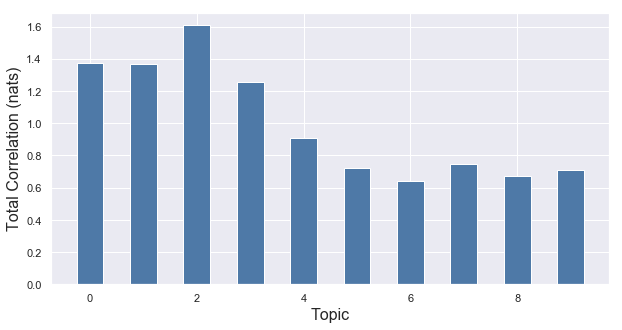

In [91]:
plt.figure(figsize=(10,5))
plt.bar(range(corex_topic_model.tcs.shape[0]), corex_topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);

In [ ]:
predictions = pd.DataFrame(corex_topic_model.labels(doc_word), columns=['topic'+str(i) for i in range(6)])

In [ ]:
plt.figure(figsize=(10,5))
plt.bar(range(corex_topic_model.tcs.shape[0]), corex_topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);

## CorEx Model FINAL - 10 Topics

In [339]:
corex_topic_model = ct.Corex(n_hidden=10, words=words, seed=1, max_iter = 400, verbose = False)
corex_topic_model.fit(doc_word, words = words, docs = df_minlen_nodupes['lemma_tweets'], 
                anchors=[['order', 'deliver', 'delivery', 'package', 'arrive'], 
                         ['ios', 'app', 'iphone', 'fix', 'phone'], 
                         ['customer', 'service', 'care', 'experience', 'tech', 'support'], 
                         ['flight', 'seat', 'fly', 'book', 'plane', 'gate', 'crew', 'bag', 'airport', 'airline'],
                         ['account', 'error', 'log', 'login', 'password', 'access'],
                         ['internet', 'reset', 'fix', 'download'], 
                         ['drive', 'cancel', 'car', 'trip'],
                         ['purchase','payment', 'card', 'refund'],
                         ['buy', 'purchase', 'deal', 'offer', 'coupon'],
                         ['music', 'tv', 'game', 'stream', 'play']], anchor_strength = 5)

In [340]:
# Print all topics from the CorEx topic model
corex_topics = corex_topic_model.get_topics()
for n,topic in enumerate(corex_topics):
    topic_words,_ = zip(*topic)
    print('{}: '.format(n) + ', '.join(topic_words))

0: order, delivery, deliver, package, arrive, prime, amazon, day, item, today
1: phone, app, fix, iphone, ios, update, battery, apple, crash, freeze
2: service, customer, support, care, experience, tech, bad, poor, terrible, loyal
3: flight, book, fly, seat, bag, plane, airport, gate, airline, crew
4: account, error, access, log, password, login, try, code, email, hack
5: fix, internet, download, reset, speed, problem, issue, outage, connection, cable
6: cancel, trip, drive, car, driver, charge, uber, ride, cancellation, park
7: card, refund, purchase, payment, credit, debit, gift, money, method, sim
8: buy, offer, purchase, deal, coupon, ticket, store, price, friday, black
9: game, play, music, stream, song, xbox, watch, video, listen, live


In [186]:
# corex_topic_model.get_top_docs(topic=9, n_docs=20)

In [341]:
predictions_10 = pd.DataFrame(corex_topic_model.p_y_given_x, columns=['topic'+str(i) for i in range(10)])
predictions_10.columns=['shopping_delivery', 'phone_gadget', 'customer_service', 'flight_travel', 'account_details', 'internet', 'car_transport', 'payment_refunds', 'deals', 'entertainment']
predictions_10.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386840 entries, 0 to 386839
Data columns (total 10 columns):
shopping_delivery    386840 non-null float64
phone_gadget         386840 non-null float64
customer_service     386840 non-null float64
flight_travel        386840 non-null float64
account_details      386840 non-null float64
internet             386840 non-null float64
car_transport        386840 non-null float64
payment_refunds      386840 non-null float64
deals                386840 non-null float64
entertainment        386840 non-null float64
dtypes: float64(10)
memory usage: 29.5 MB


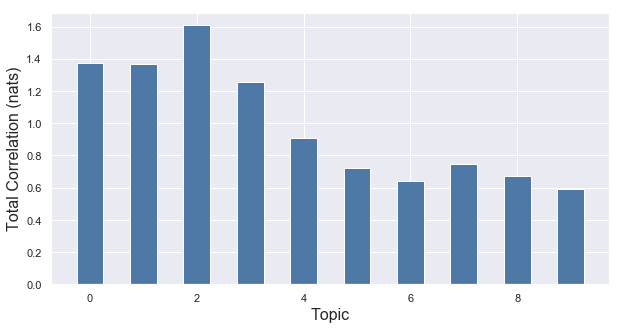

In [342]:
plt.figure(figsize=(10,5))
plt.bar(range(corex_topic_model.tcs.shape[0]), corex_topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16)
plt.savefig('corex_loadings.png', format='png', bbox_inches='tight');

## CorEx Model - 13 Topics

In [ ]:
corex_topic_model = ct.Corex(n_hidden=13, words=words, seed=1, max_iter = 400, verbose = False)
corex_topic_model.fit(doc_word, words = words, docs = df_minlen_nodupes['lemma_tweets'])


# , 
#                 anchors=[['love', 'boyfriend', 'girlfriend', 'husband', 'wife', 'wedding', 'relationship'], 
#                          ['game','win'], 
#                          ['country', 'president'], 
#                          ['shopping'],
#                          ['news'], 
#                          ['work','company', 'job'], 
#                          ['book', 'movie', 'movies', 'podcast', 'episode', 'read'],
#                          ['life'],
#                          ['congress', 'america', 'government'],
#                          ['forex', 'finance', 'trading', 'business'],
#                          ['food', 'eating', 'eat', 'drink', 'alcohol']], anchor_strength = 4

In [ ]:
# Print all topics from the CorEx topic model
corex_topics = corex_topic_model.get_topics()
for n,topic in enumerate(corex_topics):
    topic_words,_ = zip(*topic)
    print('{}: '.format(n) + ', '.join(topic_words))

In [ ]:
corex_topic_model.get_top_docs(topic=0, n_docs=4)

In [ ]:
predictions = pd.DataFrame(corex_topic_model.labels(doc_word), columns=['topic'+str(i) for i in range(6)])

In [ ]:
plt.figure(figsize=(10,5))
plt.bar(range(corex_topic_model.tcs.shape[0]), corex_topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);

# Sentiment Analysis

In [95]:
VADER_analyzer = SentimentIntensityAnalyzer()

In [96]:
def get_sentiment(x):
    sent = VADER_analyzer.polarity_scores(x)['compound']
    if sent < 0:
        return -1
    elif sent >=0:
        return 1

In [97]:
df_minlen_nodupes['sentiment'] = df_minlen_nodupes['text'].progress_apply(get_sentiment)

100%|██████████| 386840/386840 [02:26<00:00, 2642.24it/s]


In [99]:
with open('data/cs/cust_subsets/subset_df_with_sentiment.pkl', 'wb') as tweet_dump:
    pickle.dump(df_minlen_nodupes, tweet_dump)

## Overlaying Sentiment and Topic Analysis

In [237]:
df_customers_subset_raw.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,from,@
0,8,115712,True,Tue Oct 31 21:45:10 +0000 2017,@sprintcare is the worst customer service,"9,6,10",NaN,user,sprintcare
1,8,115712,True,Tue Oct 31 21:45:10 +0000 2017,@sprintcare is the worst customer service,"9,6,10",NaN,user,sprintcare
2,8,115712,True,Tue Oct 31 21:45:10 +0000 2017,@sprintcare is the worst customer service,"9,6,10",NaN,user,sprintcare
3,18,115713,True,Tue Oct 31 19:56:01 +0000 2017,@115714 y’all lie about your “great” connectio...,17,NaN,user,sprintcare
4,20,115715,True,Tue Oct 31 22:03:34 +0000 2017,"@115714 whenever I contact customer support, t...",19,NaN,user,sprintcare


In [235]:
df_customers_subset_raw['@'].unique()

array(['sprintcare', 'Ask_Spectrum', 'VerizonSupport', 'ChipotleTweets',
       'AskPlayStation', 'marksandspencer', 'MicrosoftHelps',
       'ATVIAssist', 'AdobeCare', 'AmazonHelp', 'XboxSupport',
       'AirbnbHelp', 'AirAsiaSupport', 'Morrisons', 'NikeSupport',
       'AskAmex', 'YahooCare', 'AskLyft', 'UPSHelp', 'Delta', 'McDonalds',
       'AppleSupport', 'Uber_Support', 'Tesco', 'SpotifyCares',
       'British_Airways', 'comcastcares', 'AmericanAir', 'TMobileHelp',
       'VirginTrains', 'SouthwestAir', 'AskeBay', 'hulu_support',
       'GWRHelp', 'sainsburys', 'AskPayPal', 'HPSupport', 'ChaseSupport',
       'CoxHelp', 'DropboxSupport', 'VirginAtlantic', 'BofA_Help',
       'AzureSupport', 'AlaskaAir', 'ArgosHelpers', 'Postmates_Help',
       'AskTarget', 'GoDaddyHelp', 'CenturyLinkHelp', 'AskPapaJohns',
       'SW_Help', 'nationalrailenq', 'askpanera', 'Walmart',
       'USCellularCares', 'AsurionCares', 'GloCare', 'idea_cares',
       'DoorDash_Help', 'NeweggService', 'VirginA

In [148]:
def get_company(x, ref_df):
    ID = int(x)
    return ref_df[ref_df['tweet_id'] == ID]['@'].max()

In [308]:
def get_company2(x, ref_df):
    if  np.isnan(x['company']):
        ID = int(x['tweet_id'])
        return ref_df[ref_df['tweet_id'] == ID]['@'].max()

In [269]:
df_minlen_nodupes['company'] = df_minlen_nodupes['tweet_id'].progress_apply(get_company, ref_df = df_customers_subset_raw1)



  0%|          | 0/386840 [00:00<?, ?it/s]

  0%|          | 2/386840 [00:00<17:19:50,  6.20it/s]

  0%|          | 52/386840 [00:00<12:11:42,  8.81it/s]

  0%|          | 88/386840 [00:00<8:37:31, 12.46it/s] 

  0%|          | 131/386840 [00:00<6:06:48, 17.57it/s]

  0%|          | 171/386840 [00:00<4:21:41, 24.63it/s]

  0%|          | 213/386840 [00:00<3:07:48, 34.31it/s]

  0%|          | 251/386840 [00:00<2:16:41, 47.14it/s]

  0%|          | 292/386840 [00:01<1:40:29, 64.11it/s]

  0%|          | 334/386840 [00:01<1:14:58, 85.92it/s]

  0%|          | 375/386840 [00:01<57:17, 112.43it/s] 

  0%|          | 414/386840 [00:01<47:22, 135.93it/s]

  0%|          | 461/386840 [00:01<37:17, 172.70it/s]

  0%|          | 509/386840 [00:01<30:10, 213.42it/s]

  0%|          | 557/386840 [00:01<25:09, 255.93it/s]

  0%|          | 612/386840 [00:01<21:08, 304.40it/s]

  0%|          | 663/386840 [00:01<18:35, 346.19it/s]

  0%|          | 712/386840 [00:01<16:59, 378.81it/s]

  0%|     

  3%|▎         | 12748/386840 [00:28<11:59, 519.61it/s]

  3%|▎         | 12801/386840 [00:28<12:07, 514.50it/s]

  3%|▎         | 12865/386840 [00:28<11:25, 545.60it/s]

  3%|▎         | 12921/386840 [00:28<11:28, 543.36it/s]

  3%|▎         | 12976/386840 [00:28<11:37, 536.18it/s]

  3%|▎         | 13031/386840 [00:28<11:42, 531.82it/s]

  3%|▎         | 13085/386840 [00:28<11:46, 529.03it/s]

  3%|▎         | 13139/386840 [00:28<11:49, 526.75it/s]

  3%|▎         | 13192/386840 [00:29<11:54, 522.61it/s]

  3%|▎         | 13249/386840 [00:29<11:37, 535.64it/s]

  3%|▎         | 13303/386840 [00:29<11:47, 527.64it/s]

  3%|▎         | 13357/386840 [00:29<11:43, 530.52it/s]

  3%|▎         | 13411/386840 [00:29<11:47, 528.12it/s]

  3%|▎         | 13464/386840 [00:29<11:49, 526.11it/s]

  3%|▎         | 13517/386840 [00:29<12:00, 517.89it/s]

  4%|▎         | 13569/386840 [00:29<12:07, 512.85it/s]

  4%|▎         | 13621/386840 [00:29<12:13, 508.64it/s]

  4%|▎         | 13672/386840 [

  7%|▋         | 26874/386840 [00:55<11:59, 500.44it/s]

  7%|▋         | 26925/386840 [00:55<12:14, 490.14it/s]

  7%|▋         | 26975/386840 [00:55<12:10, 492.73it/s]

  7%|▋         | 27030/386840 [00:55<11:49, 507.30it/s]

  7%|▋         | 27086/386840 [00:55<11:31, 520.30it/s]

  7%|▋         | 27139/386840 [00:55<11:32, 519.45it/s]

  7%|▋         | 27192/386840 [00:55<11:34, 517.83it/s]

  7%|▋         | 27244/386840 [00:56<11:39, 514.40it/s]

  7%|▋         | 27296/386840 [00:56<11:40, 513.37it/s]

  7%|▋         | 27348/386840 [00:56<11:45, 509.51it/s]

  7%|▋         | 27399/386840 [00:56<11:45, 509.30it/s]

  7%|▋         | 27450/386840 [00:56<11:45, 509.41it/s]

  7%|▋         | 27501/386840 [00:56<11:45, 509.34it/s]

  7%|▋         | 27552/386840 [00:56<12:19, 485.93it/s]

  7%|▋         | 27601/386840 [00:56<12:18, 486.41it/s]

  7%|▋         | 27653/386840 [00:56<12:05, 494.79it/s]

  7%|▋         | 27707/386840 [00:56<11:49, 506.34it/s]

  7%|▋         | 27758/386840 [

 10%|█         | 40583/386840 [01:22<11:13, 513.75it/s]

 11%|█         | 40635/386840 [01:22<11:20, 508.68it/s]

 11%|█         | 40690/386840 [01:22<11:06, 519.57it/s]

 11%|█         | 40743/386840 [01:22<11:07, 518.57it/s]

 11%|█         | 40795/386840 [01:22<11:20, 508.48it/s]

 11%|█         | 40850/386840 [01:23<11:05, 519.82it/s]

 11%|█         | 40903/386840 [01:23<11:20, 508.26it/s]

 11%|█         | 40954/386840 [01:23<11:33, 499.01it/s]

 11%|█         | 41005/386840 [01:23<11:36, 496.73it/s]

 11%|█         | 41060/386840 [01:23<11:17, 510.19it/s]

 11%|█         | 41112/386840 [01:23<11:14, 512.54it/s]

 11%|█         | 41164/386840 [01:23<11:14, 512.73it/s]

 11%|█         | 41216/386840 [01:23<11:18, 509.43it/s]

 11%|█         | 41268/386840 [01:23<11:21, 507.27it/s]

 11%|█         | 41319/386840 [01:23<11:26, 503.16it/s]

 11%|█         | 41371/386840 [01:24<11:21, 506.86it/s]

 11%|█         | 41422/386840 [01:24<11:23, 505.71it/s]

 11%|█         | 41475/386840 [

 14%|█▍        | 53986/386840 [01:51<10:14, 541.83it/s]

 14%|█▍        | 54055/386840 [01:51<09:35, 578.34it/s]

 14%|█▍        | 54117/386840 [01:51<09:52, 561.52it/s]

 14%|█▍        | 54176/386840 [01:52<10:59, 504.35it/s]

 14%|█▍        | 54231/386840 [01:52<10:43, 516.72it/s]

 14%|█▍        | 54285/386840 [01:52<11:14, 493.29it/s]

 14%|█▍        | 54336/386840 [01:52<11:12, 494.50it/s]

 14%|█▍        | 54390/386840 [01:52<10:57, 505.79it/s]

 14%|█▍        | 54445/386840 [01:52<10:43, 516.57it/s]

 14%|█▍        | 54498/386840 [01:52<11:19, 488.98it/s]

 14%|█▍        | 54548/386840 [01:52<11:33, 479.28it/s]

 14%|█▍        | 54597/386840 [01:52<13:37, 406.62it/s]

 14%|█▍        | 54652/386840 [01:53<12:35, 439.70it/s]

 14%|█▍        | 54714/386840 [01:53<11:29, 481.58it/s]

 14%|█▍        | 54780/386840 [01:53<10:35, 522.44it/s]

 14%|█▍        | 54844/386840 [01:53<10:00, 552.68it/s]

 14%|█▍        | 54907/386840 [01:53<09:39, 572.96it/s]

 14%|█▍        | 54976/386840 [

 19%|█▊        | 72409/386840 [02:19<06:58, 751.85it/s]

 19%|█▊        | 72485/386840 [02:20<06:57, 753.10it/s]

 19%|█▉        | 72562/386840 [02:20<06:56, 755.35it/s]

 19%|█▉        | 72638/386840 [02:20<06:55, 755.81it/s]

 19%|█▉        | 72714/386840 [02:20<06:56, 754.63it/s]

 19%|█▉        | 72792/386840 [02:20<06:53, 759.28it/s]

 19%|█▉        | 72869/386840 [02:20<06:52, 761.82it/s]

 19%|█▉        | 72946/386840 [02:20<07:00, 745.64it/s]

 19%|█▉        | 73021/386840 [02:20<07:02, 743.60it/s]

 19%|█▉        | 73098/386840 [02:20<06:59, 748.61it/s]

 19%|█▉        | 73173/386840 [02:20<06:59, 746.92it/s]

 19%|█▉        | 73252/386840 [02:21<06:53, 758.42it/s]

 19%|█▉        | 73332/386840 [02:21<06:47, 768.91it/s]

 19%|█▉        | 73411/386840 [02:21<06:45, 773.65it/s]

 19%|█▉        | 73489/386840 [02:21<06:52, 758.96it/s]

 19%|█▉        | 73566/386840 [02:21<06:56, 752.50it/s]

 19%|█▉        | 73642/386840 [02:21<07:08, 731.76it/s]

 19%|█▉        | 73716/386840 [

 23%|██▎       | 90647/386840 [02:48<08:13, 599.64it/s]

 23%|██▎       | 90717/386840 [02:48<07:52, 626.23it/s]

 23%|██▎       | 90781/386840 [02:48<08:25, 585.92it/s]

 23%|██▎       | 90841/386840 [02:48<09:00, 547.79it/s]

 23%|██▎       | 90898/386840 [02:48<09:09, 538.52it/s]

 24%|██▎       | 90953/386840 [02:48<09:11, 536.18it/s]

 24%|██▎       | 91008/386840 [02:48<09:43, 506.86it/s]

 24%|██▎       | 91060/386840 [02:48<09:54, 497.75it/s]

 24%|██▎       | 91116/386840 [02:48<09:35, 514.28it/s]

 24%|██▎       | 91171/386840 [02:49<09:25, 522.59it/s]

 24%|██▎       | 91224/386840 [02:49<09:25, 522.63it/s]

 24%|██▎       | 91277/386840 [02:49<09:27, 520.69it/s]

 24%|██▎       | 91330/386840 [02:49<09:31, 516.99it/s]

 24%|██▎       | 91382/386840 [02:49<09:42, 507.01it/s]

 24%|██▎       | 91455/386840 [02:49<08:50, 556.86it/s]

 24%|██▎       | 91523/386840 [02:49<08:23, 587.04it/s]

 24%|██▎       | 91584/386840 [02:49<09:05, 541.20it/s]

 24%|██▎       | 91640/386840 [

 28%|██▊       | 107552/386840 [03:17<10:25, 446.79it/s]

 28%|██▊       | 107623/386840 [03:17<09:16, 501.78it/s]

 28%|██▊       | 107677/386840 [03:17<10:21, 448.93it/s]

 28%|██▊       | 107739/386840 [03:17<09:31, 487.99it/s]

 28%|██▊       | 107802/386840 [03:17<08:54, 522.12it/s]

 28%|██▊       | 107868/386840 [03:17<08:22, 555.23it/s]

 28%|██▊       | 107939/386840 [03:17<07:50, 592.64it/s]

 28%|██▊       | 108011/386840 [03:17<07:26, 624.19it/s]

 28%|██▊       | 108080/386840 [03:18<07:14, 641.37it/s]

 28%|██▊       | 108146/386840 [03:18<07:23, 628.60it/s]

 28%|██▊       | 108211/386840 [03:18<07:52, 590.27it/s]

 28%|██▊       | 108276/386840 [03:18<07:40, 604.84it/s]

 28%|██▊       | 108338/386840 [03:18<08:19, 558.03it/s]

 28%|██▊       | 108402/386840 [03:18<08:01, 578.60it/s]

 28%|██▊       | 108474/386840 [03:18<07:33, 613.92it/s]

 28%|██▊       | 108537/386840 [03:19<12:32, 369.91it/s]

 28%|██▊       | 108587/386840 [03:19<17:02, 272.22it/s]

 28%|██▊      

 31%|███▏      | 121410/386840 [03:47<10:54, 405.47it/s]

 31%|███▏      | 121461/386840 [03:47<10:15, 431.35it/s]

 31%|███▏      | 121506/386840 [03:47<10:10, 434.81it/s]

 31%|███▏      | 121551/386840 [03:47<10:38, 415.24it/s]

 31%|███▏      | 121594/386840 [03:47<11:47, 374.88it/s]

 31%|███▏      | 121634/386840 [03:48<11:41, 378.29it/s]

 31%|███▏      | 121673/386840 [03:48<14:05, 313.65it/s]

 31%|███▏      | 121707/386840 [03:48<14:15, 310.00it/s]

 31%|███▏      | 121740/386840 [03:48<15:55, 277.50it/s]

 31%|███▏      | 121778/386840 [03:48<14:40, 301.19it/s]

 31%|███▏      | 121811/386840 [03:48<16:24, 269.11it/s]

 31%|███▏      | 121840/386840 [03:48<18:28, 239.11it/s]

 32%|███▏      | 121866/386840 [03:48<18:17, 241.41it/s]

 32%|███▏      | 121892/386840 [03:49<19:29, 226.47it/s]

 32%|███▏      | 121916/386840 [03:49<20:04, 219.94it/s]

 32%|███▏      | 121939/386840 [03:49<20:21, 216.80it/s]

 32%|███▏      | 121962/386840 [03:49<23:17, 189.53it/s]

 32%|███▏     

 35%|███▍      | 134767/386840 [04:18<07:16, 577.00it/s]

 35%|███▍      | 134844/386840 [04:18<06:44, 622.76it/s]

 35%|███▍      | 134922/386840 [04:19<06:20, 661.32it/s]

 35%|███▍      | 134998/386840 [04:19<06:06, 686.80it/s]

 35%|███▍      | 135071/386840 [04:19<06:01, 696.60it/s]

 35%|███▍      | 135144/386840 [04:19<06:02, 693.39it/s]

 35%|███▍      | 135216/386840 [04:19<06:07, 685.16it/s]

 35%|███▍      | 135286/386840 [04:19<06:20, 660.91it/s]

 35%|███▍      | 135354/386840 [04:19<06:22, 658.06it/s]

 35%|███▌      | 135428/386840 [04:19<06:09, 680.27it/s]

 35%|███▌      | 135498/386840 [04:19<06:07, 684.82it/s]

 35%|███▌      | 135574/386840 [04:20<05:56, 705.76it/s]

 35%|███▌      | 135650/386840 [04:20<05:48, 720.74it/s]

 35%|███▌      | 135723/386840 [04:20<05:50, 716.03it/s]

 35%|███▌      | 135799/386840 [04:20<05:44, 727.66it/s]

 35%|███▌      | 135873/386840 [04:20<05:59, 697.23it/s]

 35%|███▌      | 135944/386840 [04:20<06:06, 684.09it/s]

 35%|███▌     

 39%|███▉      | 151915/386840 [04:48<05:20, 733.22it/s]

 39%|███▉      | 151994/386840 [04:48<05:14, 747.62it/s]

 39%|███▉      | 152070/386840 [04:48<05:15, 743.31it/s]

 39%|███▉      | 152145/386840 [04:48<05:21, 729.87it/s]

 39%|███▉      | 152219/386840 [04:48<07:09, 545.92it/s]

 39%|███▉      | 152281/386840 [04:48<07:58, 490.15it/s]

 39%|███▉      | 152336/386840 [04:49<08:18, 470.55it/s]

 39%|███▉      | 152398/386840 [04:49<07:43, 505.99it/s]

 39%|███▉      | 152453/386840 [04:49<08:56, 436.85it/s]

 39%|███▉      | 152502/386840 [04:49<09:05, 429.74it/s]

 39%|███▉      | 152549/386840 [04:49<10:05, 387.24it/s]

 39%|███▉      | 152615/386840 [04:49<08:50, 441.47it/s]

 39%|███▉      | 152664/386840 [04:49<08:58, 435.03it/s]

 39%|███▉      | 152711/386840 [04:49<09:47, 398.64it/s]

 39%|███▉      | 152754/386840 [04:50<09:44, 400.54it/s]

 39%|███▉      | 152797/386840 [04:50<09:54, 393.48it/s]

 40%|███▉      | 152864/386840 [04:50<08:42, 448.21it/s]

 40%|███▉     

 44%|████▍     | 170232/386840 [05:16<04:35, 784.84it/s]

 44%|████▍     | 170312/386840 [05:16<04:35, 786.68it/s]

 44%|████▍     | 170391/386840 [05:16<04:36, 783.70it/s]

 44%|████▍     | 170471/386840 [05:16<04:34, 787.02it/s]

 44%|████▍     | 170551/386840 [05:16<04:34, 789.23it/s]

 44%|████▍     | 170630/386840 [05:16<04:33, 789.32it/s]

 44%|████▍     | 170709/386840 [05:16<04:38, 776.52it/s]

 44%|████▍     | 170789/386840 [05:16<04:36, 780.77it/s]

 44%|████▍     | 170868/386840 [05:17<04:36, 780.91it/s]

 44%|████▍     | 170947/386840 [05:17<04:36, 779.92it/s]

 44%|████▍     | 171026/386840 [05:17<04:35, 782.89it/s]

 44%|████▍     | 171105/386840 [05:17<04:35, 783.63it/s]

 44%|████▍     | 171184/386840 [05:17<04:34, 784.44it/s]

 44%|████▍     | 171263/386840 [05:17<04:36, 779.18it/s]

 44%|████▍     | 171341/386840 [05:17<04:36, 779.14it/s]

 44%|████▍     | 171419/386840 [05:17<04:37, 776.33it/s]

 44%|████▍     | 171497/386840 [05:17<04:41, 765.24it/s]

 44%|████▍    

 49%|████▊     | 188196/386840 [05:44<06:07, 540.93it/s]

 49%|████▊     | 188255/386840 [05:44<05:58, 553.39it/s]

 49%|████▊     | 188314/386840 [05:44<05:53, 561.66it/s]

 49%|████▊     | 188371/386840 [05:44<05:53, 562.02it/s]

 49%|████▊     | 188428/386840 [05:44<06:01, 549.23it/s]

 49%|████▊     | 188484/386840 [05:44<06:49, 484.09it/s]

 49%|████▊     | 188539/386840 [05:44<06:35, 500.97it/s]

 49%|████▉     | 188596/386840 [05:45<06:21, 519.80it/s]

 49%|████▉     | 188653/386840 [05:45<06:12, 531.69it/s]

 49%|████▉     | 188713/386840 [05:45<06:00, 549.38it/s]

 49%|████▉     | 188773/386840 [05:45<05:52, 561.94it/s]

 49%|████▉     | 188833/386840 [05:45<05:46, 571.49it/s]

 49%|████▉     | 188891/386840 [05:45<05:56, 555.37it/s]

 49%|████▉     | 188947/386840 [05:45<06:32, 504.66it/s]

 49%|████▉     | 188999/386840 [05:45<06:51, 480.67it/s]

 49%|████▉     | 189049/386840 [05:45<07:44, 425.75it/s]

 49%|████▉     | 189094/386840 [05:46<09:27, 348.53it/s]

 49%|████▉    

 51%|█████▏    | 198712/386840 [06:16<10:53, 287.92it/s]

 51%|█████▏    | 198743/386840 [06:16<11:25, 274.41it/s]

 51%|█████▏    | 198785/386840 [06:16<10:16, 305.08it/s]

 51%|█████▏    | 198821/386840 [06:16<10:00, 313.33it/s]

 51%|█████▏    | 198854/386840 [06:16<10:01, 312.67it/s]

 51%|█████▏    | 198888/386840 [06:16<09:47, 319.72it/s]

 51%|█████▏    | 198926/386840 [06:16<09:21, 334.80it/s]

 51%|█████▏    | 198961/386840 [06:16<09:22, 334.16it/s]

 51%|█████▏    | 198998/386840 [06:17<09:07, 342.98it/s]

 51%|█████▏    | 199033/386840 [06:17<09:55, 315.39it/s]

 51%|█████▏    | 199067/386840 [06:17<09:47, 319.84it/s]

 51%|█████▏    | 199100/386840 [06:17<10:36, 295.08it/s]

 51%|█████▏    | 199131/386840 [06:17<11:09, 280.56it/s]

 51%|█████▏    | 199160/386840 [06:17<11:45, 266.00it/s]

 51%|█████▏    | 199188/386840 [06:17<12:07, 257.85it/s]

 51%|█████▏    | 199218/386840 [06:17<11:39, 268.13it/s]

 52%|█████▏    | 199251/386840 [06:17<11:03, 282.66it/s]

 52%|█████▏   

 55%|█████▌    | 213688/386840 [06:45<04:12, 686.70it/s]

 55%|█████▌    | 213761/386840 [06:45<04:07, 699.00it/s]

 55%|█████▌    | 213836/386840 [06:45<04:02, 712.28it/s]

 55%|█████▌    | 213914/386840 [06:45<03:56, 729.90it/s]

 55%|█████▌    | 213993/386840 [06:46<03:52, 744.59it/s]

 55%|█████▌    | 214070/386840 [06:46<03:50, 750.62it/s]

 55%|█████▌    | 214146/386840 [06:46<03:54, 735.90it/s]

 55%|█████▌    | 214220/386840 [06:46<04:08, 695.13it/s]

 55%|█████▌    | 214291/386840 [06:46<04:20, 662.90it/s]

 55%|█████▌    | 214359/386840 [06:46<04:26, 647.50it/s]

 55%|█████▌    | 214425/386840 [06:46<04:35, 626.30it/s]

 55%|█████▌    | 214489/386840 [06:46<04:38, 619.46it/s]

 55%|█████▌    | 214552/386840 [06:46<04:49, 594.67it/s]

 55%|█████▌    | 214615/386840 [06:47<04:45, 604.04it/s]

 55%|█████▌    | 214686/386840 [06:47<04:33, 630.24it/s]

 56%|█████▌    | 214750/386840 [06:47<04:32, 630.70it/s]

 56%|█████▌    | 214814/386840 [06:47<04:32, 630.47it/s]

 56%|█████▌   

 60%|██████    | 232237/386840 [07:12<03:19, 775.80it/s]

 60%|██████    | 232315/386840 [07:12<03:22, 763.37it/s]

 60%|██████    | 232393/386840 [07:12<03:21, 766.87it/s]

 60%|██████    | 232471/386840 [07:12<03:20, 769.87it/s]

 60%|██████    | 232552/386840 [07:13<03:17, 779.44it/s]

 60%|██████    | 232630/386840 [07:13<03:18, 777.65it/s]

 60%|██████    | 232709/386840 [07:13<03:17, 780.61it/s]

 60%|██████    | 232788/386840 [07:13<03:18, 777.14it/s]

 60%|██████    | 232866/386840 [07:13<03:18, 774.87it/s]

 60%|██████    | 232946/386840 [07:13<03:17, 779.73it/s]

 60%|██████    | 233026/386840 [07:13<03:16, 783.00it/s]

 60%|██████    | 233105/386840 [07:13<03:17, 779.35it/s]

 60%|██████    | 233184/386840 [07:13<03:16, 781.13it/s]

 60%|██████    | 233263/386840 [07:13<03:16, 783.32it/s]

 60%|██████    | 233343/386840 [07:14<03:15, 787.04it/s]

 60%|██████    | 233423/386840 [07:14<03:14, 789.33it/s]

 60%|██████    | 233503/386840 [07:14<03:14, 790.17it/s]

 60%|██████   

 65%|██████▌   | 252357/386840 [07:38<02:56, 761.34it/s]

 65%|██████▌   | 252435/386840 [07:38<02:55, 765.50it/s]

 65%|██████▌   | 252514/386840 [07:39<02:54, 770.97it/s]

 65%|██████▌   | 252592/386840 [07:39<02:54, 767.65it/s]

 65%|██████▌   | 252671/386840 [07:39<02:53, 773.95it/s]

 65%|██████▌   | 252749/386840 [07:39<02:53, 773.82it/s]

 65%|██████▌   | 252829/386840 [07:39<02:52, 779.11it/s]

 65%|██████▌   | 252908/386840 [07:39<02:51, 781.83it/s]

 65%|██████▌   | 252988/386840 [07:39<02:50, 784.67it/s]

 65%|██████▌   | 253067/386840 [07:39<02:53, 770.43it/s]

 65%|██████▌   | 253145/386840 [07:39<02:55, 761.27it/s]

 65%|██████▌   | 253224/386840 [07:39<02:53, 769.15it/s]

 65%|██████▌   | 253304/386840 [07:40<02:52, 775.59it/s]

 66%|██████▌   | 253383/386840 [07:40<02:51, 779.75it/s]

 66%|██████▌   | 253462/386840 [07:40<02:50, 780.77it/s]

 66%|██████▌   | 253541/386840 [07:40<02:50, 782.86it/s]

 66%|██████▌   | 253620/386840 [07:40<02:49, 784.00it/s]

 66%|██████▌  

 70%|███████   | 272104/386840 [08:05<02:27, 777.95it/s]

 70%|███████   | 272183/386840 [08:05<02:27, 779.49it/s]

 70%|███████   | 272262/386840 [08:05<02:26, 781.67it/s]

 70%|███████   | 272341/386840 [08:05<02:27, 776.89it/s]

 70%|███████   | 272419/386840 [08:05<02:28, 768.02it/s]

 70%|███████   | 272498/386840 [08:05<02:27, 772.85it/s]

 70%|███████   | 272577/386840 [08:06<02:27, 775.77it/s]

 70%|███████   | 272655/386840 [08:06<02:34, 738.18it/s]

 71%|███████   | 272730/386840 [08:06<02:41, 706.04it/s]

 71%|███████   | 272809/386840 [08:06<02:36, 727.92it/s]

 71%|███████   | 272886/386840 [08:06<02:34, 738.67it/s]

 71%|███████   | 272963/386840 [08:06<02:32, 746.45it/s]

 71%|███████   | 273043/386840 [08:06<02:29, 759.06it/s]

 71%|███████   | 273120/386840 [08:06<02:29, 758.73it/s]

 71%|███████   | 273199/386840 [08:06<02:28, 765.72it/s]

 71%|███████   | 273278/386840 [08:06<02:27, 770.35it/s]

 71%|███████   | 273358/386840 [08:07<02:26, 776.42it/s]

 71%|███████  

 76%|███████▌  | 292268/386840 [08:31<02:00, 784.75it/s]

 76%|███████▌  | 292347/386840 [08:31<02:00, 781.44it/s]

 76%|███████▌  | 292426/386840 [08:31<02:01, 775.60it/s]

 76%|███████▌  | 292504/386840 [08:31<02:01, 775.54it/s]

 76%|███████▌  | 292584/386840 [08:31<02:00, 781.58it/s]

 76%|███████▌  | 292663/386840 [08:32<02:00, 781.71it/s]

 76%|███████▌  | 292742/386840 [08:32<02:00, 780.54it/s]

 76%|███████▌  | 292822/386840 [08:32<01:59, 784.17it/s]

 76%|███████▌  | 292903/386840 [08:32<01:59, 789.33it/s]

 76%|███████▌  | 292982/386840 [08:32<01:59, 786.45it/s]

 76%|███████▌  | 293062/386840 [08:32<01:58, 788.49it/s]

 76%|███████▌  | 293141/386840 [08:32<01:58, 788.38it/s]

 76%|███████▌  | 293220/386840 [08:32<01:59, 785.29it/s]

 76%|███████▌  | 293299/386840 [08:32<01:59, 780.99it/s]

 76%|███████▌  | 293379/386840 [08:32<01:59, 783.92it/s]

 76%|███████▌  | 293459/386840 [08:33<01:58, 786.54it/s]

 76%|███████▌  | 293538/386840 [08:33<01:58, 786.88it/s]

 76%|███████▌ 

 81%|████████  | 312484/386840 [08:57<01:34, 788.63it/s]

 81%|████████  | 312563/386840 [08:57<01:34, 782.58it/s]

 81%|████████  | 312642/386840 [08:57<01:34, 782.65it/s]

 81%|████████  | 312722/386840 [08:57<01:34, 786.07it/s]

 81%|████████  | 312802/386840 [08:58<01:33, 789.20it/s]

 81%|████████  | 312882/386840 [08:58<01:33, 791.06it/s]

 81%|████████  | 312962/386840 [08:58<01:33, 790.61it/s]

 81%|████████  | 313042/386840 [08:58<01:33, 792.52it/s]

 81%|████████  | 313122/386840 [08:58<01:33, 790.10it/s]

 81%|████████  | 313202/386840 [08:58<01:33, 787.03it/s]

 81%|████████  | 313281/386840 [08:58<01:33, 783.21it/s]

 81%|████████  | 313360/386840 [08:58<01:34, 781.28it/s]

 81%|████████  | 313439/386840 [08:58<01:33, 781.64it/s]

 81%|████████  | 313518/386840 [08:58<01:33, 780.34it/s]

 81%|████████  | 313597/386840 [08:59<01:33, 779.87it/s]

 81%|████████  | 313675/386840 [08:59<01:37, 752.63it/s]

 81%|████████  | 313751/386840 [08:59<01:44, 701.44it/s]

 81%|████████ 

 86%|████████▌ | 332636/386840 [09:23<01:09, 781.18it/s]

 86%|████████▌ | 332715/386840 [09:23<01:09, 780.95it/s]

 86%|████████▌ | 332794/386840 [09:23<01:08, 783.43it/s]

 86%|████████▌ | 332874/386840 [09:24<01:08, 786.32it/s]

 86%|████████▌ | 332953/386840 [09:24<01:08, 784.98it/s]

 86%|████████▌ | 333032/386840 [09:24<01:08, 783.64it/s]

 86%|████████▌ | 333111/386840 [09:24<01:08, 783.00it/s]

 86%|████████▌ | 333190/386840 [09:24<01:08, 778.22it/s]

 86%|████████▌ | 333269/386840 [09:24<01:08, 780.47it/s]

 86%|████████▌ | 333348/386840 [09:24<01:08, 781.08it/s]

 86%|████████▌ | 333427/386840 [09:24<01:09, 773.40it/s]

 86%|████████▌ | 333505/386840 [09:24<01:09, 763.09it/s]

 86%|████████▌ | 333582/386840 [09:24<01:10, 760.38it/s]

 86%|████████▋ | 333660/386840 [09:25<01:09, 764.33it/s]

 86%|████████▋ | 333738/386840 [09:25<01:09, 767.21it/s]

 86%|████████▋ | 333817/386840 [09:25<01:08, 772.31it/s]

 86%|████████▋ | 333896/386840 [09:25<01:08, 777.24it/s]

 86%|████████▋

 91%|█████████ | 352866/386840 [09:49<00:45, 745.32it/s]

 91%|█████████ | 352941/386840 [09:49<00:46, 729.06it/s]

 91%|█████████▏| 353015/386840 [09:49<00:47, 717.21it/s]

 91%|█████████▏| 353093/386840 [09:50<00:45, 733.87it/s]

 91%|█████████▏| 353172/386840 [09:50<00:45, 747.53it/s]

 91%|█████████▏| 353251/386840 [09:50<00:44, 758.04it/s]

 91%|█████████▏| 353328/386840 [09:50<00:44, 759.70it/s]

 91%|█████████▏| 353407/386840 [09:50<00:43, 766.72it/s]

 91%|█████████▏| 353485/386840 [09:50<00:43, 769.83it/s]

 91%|█████████▏| 353563/386840 [09:50<00:43, 772.31it/s]

 91%|█████████▏| 353641/386840 [09:50<00:43, 770.63it/s]

 91%|█████████▏| 353720/386840 [09:50<00:42, 775.65it/s]

 91%|█████████▏| 353800/386840 [09:50<00:42, 781.08it/s]

 91%|█████████▏| 353879/386840 [09:51<00:42, 779.98it/s]

 92%|█████████▏| 353959/386840 [09:51<00:41, 783.92it/s]

 92%|█████████▏| 354038/386840 [09:51<00:41, 785.22it/s]

 92%|█████████▏| 354117/386840 [09:51<00:41, 783.12it/s]

 92%|█████████

 96%|█████████▌| 370931/386840 [10:17<00:56, 280.96it/s]

 96%|█████████▌| 370960/386840 [10:17<01:00, 264.00it/s]

 96%|█████████▌| 370987/386840 [10:17<01:00, 260.01it/s]

 96%|█████████▌| 371014/386840 [10:17<01:02, 255.20it/s]

 96%|█████████▌| 371044/386840 [10:18<00:59, 265.79it/s]

 96%|█████████▌| 371073/386840 [10:18<00:57, 272.07it/s]

 96%|█████████▌| 371101/386840 [10:18<00:57, 273.75it/s]

 96%|█████████▌| 371133/386840 [10:18<00:55, 285.21it/s]

 96%|█████████▌| 371162/386840 [10:18<00:54, 286.42it/s]

 96%|█████████▌| 371191/386840 [10:18<00:56, 279.01it/s]

 96%|█████████▌| 371221/386840 [10:18<00:55, 283.75it/s]

 96%|█████████▌| 371259/386840 [10:18<00:50, 306.17it/s]

 96%|█████████▌| 371291/386840 [10:18<00:51, 304.08it/s]

 96%|█████████▌| 371322/386840 [10:18<00:52, 297.60it/s]

 96%|█████████▌| 371353/386840 [10:19<00:52, 297.71it/s]

 96%|█████████▌| 371386/386840 [10:19<00:50, 305.25it/s]

 96%|█████████▌| 371417/386840 [10:19<00:51, 298.52it/s]

 96%|█████████

 99%|█████████▊| 381711/386840 [10:45<00:19, 258.97it/s]

 99%|█████████▊| 381739/386840 [10:45<00:20, 251.54it/s]

 99%|█████████▊| 381777/386840 [10:46<00:18, 279.40it/s]

 99%|█████████▊| 381817/386840 [10:46<00:16, 306.12it/s]

 99%|█████████▊| 381853/386840 [10:46<00:15, 320.03it/s]

 99%|█████████▊| 381892/386840 [10:46<00:14, 338.21it/s]

 99%|█████████▊| 381936/386840 [10:46<00:13, 362.80it/s]

 99%|█████████▊| 381974/386840 [10:46<00:13, 362.33it/s]

 99%|█████████▉| 382012/386840 [10:46<00:14, 326.72it/s]

 99%|█████████▉| 382047/386840 [10:46<00:15, 318.71it/s]

 99%|█████████▉| 382080/386840 [10:46<00:15, 316.01it/s]

 99%|█████████▉| 382116/386840 [10:47<00:14, 327.38it/s]

 99%|█████████▉| 382150/386840 [10:47<00:14, 322.45it/s]

 99%|█████████▉| 382185/386840 [10:47<00:14, 326.21it/s]

 99%|█████████▉| 382218/386840 [10:47<00:14, 310.27it/s]

 99%|█████████▉| 382250/386840 [10:47<00:15, 302.45it/s]

 99%|█████████▉| 382281/386840 [10:47<00:15, 300.96it/s]

 99%|█████████

In [324]:
# df_minlen_nodupes['@'][]

In [351]:
df_minlen_nodupes.loc[3,'company']

nan

In [352]:
for idx, row in df_minlen_nodupes.iterrows():
    print('Row: {}'.format(idx))
    if pd.isnull(row['company']):
        print('empty row')
        ID = ID = int(row['tweet_id'])
        print('Tweet ID is: {}'.format(ID))
        print('Company should be: {}'.format(df_customers_subset_raw2[df_customers_subset_raw2['tweet_id'] == ID]['@'].max()))
        df_minlen_nodupes.loc[idx, 'company'] = df_customers_subset_raw2[df_customers_subset_raw2['tweet_id'] == ID]['@'].max()
    display.clear_output(wait=True)

# df_minlen_nodupes['company'] = df_minlen_nodupes.progress_apply(get_company2, ref_df = df_customers_subset_raw2)

Row: 386839
empty row
Tweet ID is: 1012199
Company should be: sainsburys


In [357]:
with open('data/cs/cust_subsets/sentiment_with_companies_raw.pkl', 'wb') as tweet_dump:
    pickle.dump(df_minlen_nodupes, tweet_dump)

In [432]:
with open('data/cs/cust_subsets/sentiment_with_companies_raw.pkl', 'rb') as tweet_load:
    df_minlen_nodupes = pickle.load(tweet_load)

In [433]:
df_minlen_nodupes[pd.isnull(df_minlen_nodupes['company'])].shape

(54708, 12)

In [438]:
df_minlen_nodupes.reset_index(drop=True, inplace=True)

In [439]:
analyzed_df = pd.concat([df_minlen_nodupes, predictions_10], axis=1)

In [442]:
analyzed_df.head(10)

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,from,tweet_len,lemma_tweets,...,shopping_delivery,phone_gadget,customer_service,flight_travel,account_details,internet,car_transport,payment_refunds,deals,entertainment
0,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,I have sent several private messages and no ...,1,4.0,user,72,have send several private message and no o...,...,0.000012,0.000071,0.000018,0.000002,0.000078,0.000063,0.000027,0.000049,0.000067,0.000016
1,12,115713,True,Tue Oct 31 22:04:47 +0000 2017,You gonna magically change your connectivity...,"11,13,14",15.0,user,79,go to magically change connectivity for ...,...,0.000012,0.000071,0.000014,0.000071,0.000053,0.000063,0.000028,0.000049,0.000074,0.000017
2,16,115713,True,Tue Oct 31 20:00:43 +0000 2017,Since I signed up with you....Since day 1,15,17.0,user,43,since sign up with .... since day 1,...,0.000039,0.000071,0.000014,0.000029,0.000083,0.000063,0.000028,0.000049,0.000074,0.000017
3,18,115713,True,Tue Oct 31 19:56:01 +0000 2017,y’all lie about your “great” connection. 5 b...,17,NaN,user,87,"all lie about "" great "" connection . 5 ba...",...,0.000009,0.000073,0.000042,0.000001,0.000019,0.000318,0.000027,0.000049,0.000073,0.000064
4,20,115715,True,Tue Oct 31 22:03:34 +0000 2017,"whenever I contact customer support, they te...",19,NaN,user,136,"whenever contact customer support , tell ...",...,0.000020,0.000179,0.999999,0.000029,0.999999,0.000063,0.000028,0.000050,0.000078,0.000017
9,29,115716,True,Tue Oct 31 22:01:35 +0000 2017,actually that's a broken link you sent me and ...,28,NaN,user,69,actual that be a broken link send and incorr...,...,0.000015,0.000075,0.000014,0.000013,0.000538,0.000166,0.000028,0.000049,0.000074,0.000015
10,31,115717,True,Tue Oct 31 22:06:54 +0000 2017,Yo your customer service reps are super nice...,30,NaN,user,107,Yo customer service rep be super nice— but...,...,0.000012,0.000071,0.999999,0.000089,0.000018,0.000063,0.000028,0.000049,0.000074,0.000043
11,33,115718,True,Tue Oct 31 22:06:56 +0000 2017,My picture on pretty much every day. Why sho...,32,NaN,user,73,picture on pretty much every day . why sho...,...,0.000039,0.000071,0.000006,0.000029,0.000011,0.000063,0.000028,0.000215,0.000077,0.000017
12,35,115719,True,Tue Oct 31 22:49:16 +0000 2017,"I finally got someone that helped me, thanks!",37,34.0,user,47,"finally get someone that help , thank !",...,0.000010,0.000070,0.000014,0.000029,0.000044,0.000063,0.000028,0.000049,0.000072,0.000017
13,36,115719,True,Tue Oct 31 22:10:46 +0000 2017,somebody from please help meeeeee 😩😩😩😩 I'm h...,34,NaN,user,93,somebody from please help meeeeee 😩 😩 😩 😩 ...,...,0.000012,0.000103,0.999999,0.000029,0.000045,0.000064,0.000028,0.000049,0.000074,0.000017


In [441]:
analyzed_df.dropna(subset=['company'], axis=0, inplace=True)

In [375]:
def remove_ats(x):
    return re.sub('@', '', x)

In [444]:
analyzed_df['company'] = analyzed_df['company'].astype('str') 
analyzed_df['company'] = analyzed_df['company'].progress_apply(remove_ats)









  0%|          | 0/332132 [00:00<?, ?it/s]







  9%|▉         | 31396/332132 [00:00<00:00, 313940.84it/s]







 15%|█▌        | 50426/332132 [00:00<00:01, 262727.24it/s]







 22%|██▏       | 74165/332132 [00:00<00:01, 254574.11it/s]







 31%|███       | 102361/332132 [00:00<00:00, 262213.90it/s]







 40%|████      | 134073/332132 [00:00<00:00, 276579.21it/s]







 47%|████▋     | 157217/332132 [00:00<00:00, 256864.38it/s]







 56%|█████▌    | 185651/332132 [00:00<00:00, 264531.54it/s]







 65%|██████▍   | 214227/332132 [00:00<00:00, 270559.78it/s]







 73%|███████▎  | 241073/332132 [00:00<00:00, 269800.95it/s]







 80%|████████  | 267118/332132 [00:01<00:00, 266907.79it/s]







 90%|█████████ | 299797/332132 [00:01<00:00, 282433.97it/s]







100%|█████████▉| 330749/332132 [00:01<00:00, 290047.70it/s]







100%|██████████| 332132/332132 [00:01<00:00, 269711.13it/s]

In [445]:
# df_minlen_nodupes.head(10)

In [407]:
predictions_10.columns

Index(['shopping_delivery', 'phone_gadget', 'customer_service',
       'flight_travel', 'account_details', 'internet', 'car_transport',
       'payment_refunds', 'deals', 'entertainment'],
      dtype='object')

In [446]:
analyzed_df['top_topic'] = analyzed_df[['shopping_delivery', 'phone_gadget', 'customer_service', 'flight_travel', 'account_details', 'internet', 'car_transport', 'internet', 'payment_refunds', 'entertainment']].idxmax(axis=1)

In [ ]:
# analyzed_df['top_'] = analyzed_df[['shopping_delivery', 'phone_gadget', 'customer_service', 'flight_travel', 'account_details', 'internet', 'car_transport', 'internet', 'payment_refunds', 'entertainment']].idxmax(axis=1)

In [447]:
del analyzed_df['inbound'] 
del analyzed_df['created_at'] 
del analyzed_df['response_tweet_id'] 
del analyzed_df['in_response_to_tweet_id']

In [448]:
analyzed_df.head(10)

,tweet_id,author_id,text,from,tweet_len,lemma_tweets,sentiment,company,shopping_delivery,phone_gadget,customer_service,flight_travel,account_details,internet,car_transport,payment_refunds,deals,entertainment,top_topic
0,3,115712,I have sent several private messages and no ...,user,72,have send several private message and no o...,-1,sprintcare,0.000012,0.000071,0.000018,0.000002,0.000078,0.000063,0.000027,0.000049,0.000067,0.000016,account_details
1,12,115713,You gonna magically change your connectivity...,user,79,go to magically change connectivity for ...,-1,sprintcare,0.000012,0.000071,0.000014,0.000071,0.000053,0.000063,0.000028,0.000049,0.000074,0.000017,phone_gadget
2,16,115713,Since I signed up with you....Since day 1,user,43,since sign up with .... since day 1,1,sprintcare,0.000039,0.000071,0.000014,0.000029,0.000083,0.000063,0.000028,0.000049,0.000074,0.000017,account_details
3,18,115713,y’all lie about your “great” connection. 5 b...,user,87,"all lie about "" great "" connection . 5 ba...",-1,sprintcare,0.000009,0.000073,0.000042,0.000001,0.000019,0.000318,0.000027,0.000049,0.000073,0.000064,internet
4,20,115715,"whenever I contact customer support, they te...",user,136,"whenever contact customer support , tell ...",1,sprintcare,0.000020,0.000179,0.999999,0.000029,0.999999,0.000063,0.000028,0.000050,0.000078,0.000017,customer_service
9,29,115716,actually that's a broken link you sent me and ...,user,69,actual that be a broken link send and incorr...,-1,Ask_Spectrum,0.000015,0.000075,0.000014,0.000013,0.000538,0.000166,0.000028,0.000049,0.000074,0.000015,account_details
10,31,115717,Yo your customer service reps are super nice...,user,107,Yo customer service rep be super nice— but...,1,Ask_Spectrum,0.000012,0.000071,0.999999,0.000089,0.000018,0.000063,0.000028,0.000049,0.000074,0.000043,customer_service
11,33,115718,My picture on pretty much every day. Why sho...,user,73,picture on pretty much every day . why sho...,1,Ask_Spectrum,0.000039,0.000071,0.000006,0.000029,0.000011,0.000063,0.000028,0.000215,0.000077,0.000017,payment_refunds
12,35,115719,"I finally got someone that helped me, thanks!",user,47,"finally get someone that help , thank !",1,VerizonSupport,0.000010,0.000070,0.000014,0.000029,0.000044,0.000063,0.000028,0.000049,0.000072,0.000017,phone_gadget
13,36,115719,somebody from please help meeeeee 😩😩😩😩 I'm h...,user,93,somebody from please help meeeeee 😩 😩 😩 😩 ...,1,VerizonSupport,0.000012,0.000103,0.999999,0.000029,0.000045,0.000064,0.000028,0.000049,0.000074,0.000017,customer_service


In [449]:
analyzed_df['shopping_delivery_sent'] = analyzed_df['sentiment'] * analyzed_df['shopping_delivery']
analyzed_df['phone_gadget_sent'] = analyzed_df['sentiment'] * analyzed_df['phone_gadget']
analyzed_df['customer_service_sent'] = analyzed_df['sentiment'] * analyzed_df['customer_service']
analyzed_df['flight_travel_sent'] = analyzed_df['sentiment'] * analyzed_df['flight_travel']
analyzed_df['account_details_sent'] = analyzed_df['sentiment'] * analyzed_df['account_details']
analyzed_df['internet_sent'] = analyzed_df['sentiment'] * analyzed_df['internet']
analyzed_df['car_transport_sent'] = analyzed_df['sentiment'] * analyzed_df['car_transport']
analyzed_df['payment_refunds_sent'] = analyzed_df['sentiment'] * analyzed_df['payment_refunds']
analyzed_df['deals_sent'] = analyzed_df['sentiment'] * analyzed_df['deals']
analyzed_df['entertainment_sent'] = analyzed_df['sentiment'] * analyzed_df['entertainment']

In [450]:
analyzed_df.head(10)

,tweet_id,author_id,text,from,tweet_len,lemma_tweets,sentiment,company,shopping_delivery,phone_gadget,...,shopping_delivery_sent,phone_gadget_sent,customer_service_sent,flight_travel_sent,account_details_sent,internet_sent,car_transport_sent,payment_refunds_sent,deals_sent,entertainment_sent
0,3,115712,I have sent several private messages and no ...,user,72,have send several private message and no o...,-1,sprintcare,0.000012,0.000071,...,-0.000012,-0.000071,-0.000018,-0.000002,-0.000078,-0.000063,-0.000027,-0.000049,-0.000067,-0.000016
1,12,115713,You gonna magically change your connectivity...,user,79,go to magically change connectivity for ...,-1,sprintcare,0.000012,0.000071,...,-0.000012,-0.000071,-0.000014,-0.000071,-0.000053,-0.000063,-0.000028,-0.000049,-0.000074,-0.000017
2,16,115713,Since I signed up with you....Since day 1,user,43,since sign up with .... since day 1,1,sprintcare,0.000039,0.000071,...,0.000039,0.000071,0.000014,0.000029,0.000083,0.000063,0.000028,0.000049,0.000074,0.000017
3,18,115713,y’all lie about your “great” connection. 5 b...,user,87,"all lie about "" great "" connection . 5 ba...",-1,sprintcare,0.000009,0.000073,...,-0.000009,-0.000073,-0.000042,-0.000001,-0.000019,-0.000318,-0.000027,-0.000049,-0.000073,-0.000064
4,20,115715,"whenever I contact customer support, they te...",user,136,"whenever contact customer support , tell ...",1,sprintcare,0.000020,0.000179,...,0.000020,0.000179,0.999999,0.000029,0.999999,0.000063,0.000028,0.000050,0.000078,0.000017
9,29,115716,actually that's a broken link you sent me and ...,user,69,actual that be a broken link send and incorr...,-1,Ask_Spectrum,0.000015,0.000075,...,-0.000015,-0.000075,-0.000014,-0.000013,-0.000538,-0.000166,-0.000028,-0.000049,-0.000074,-0.000015
10,31,115717,Yo your customer service reps are super nice...,user,107,Yo customer service rep be super nice— but...,1,Ask_Spectrum,0.000012,0.000071,...,0.000012,0.000071,0.999999,0.000089,0.000018,0.000063,0.000028,0.000049,0.000074,0.000043
11,33,115718,My picture on pretty much every day. Why sho...,user,73,picture on pretty much every day . why sho...,1,Ask_Spectrum,0.000039,0.000071,...,0.000039,0.000071,0.000006,0.000029,0.000011,0.000063,0.000028,0.000215,0.000077,0.000017
12,35,115719,"I finally got someone that helped me, thanks!",user,47,"finally get someone that help , thank !",1,VerizonSupport,0.000010,0.000070,...,0.000010,0.000070,0.000014,0.000029,0.000044,0.000063,0.000028,0.000049,0.000072,0.000017
13,36,115719,somebody from please help meeeeee 😩😩😩😩 I'm h...,user,93,somebody from please help meeeeee 😩 😩 😩 😩 ...,1,VerizonSupport,0.000012,0.000103,...,0.000012,0.000103,0.999999,0.000029,0.000045,0.000064,0.000028,0.000049,0.000074,0.000017


In [452]:
with open('data/cs/cust_subsets/topic_sentiment_with_companies.pkl', 'wb') as tweet_dump:
    pickle.dump(analyzed_df, tweet_dump)

In [249]:
with open('data/cs/cust_subsets/topic_sentiment_with_companies.pkl', 'rb') as tweet_load:
    analyzed_df = pickle.load(tweet_load)

# Exploring topics v companies

In [464]:
top_companies = analyzed_df['company'].value_counts().index[0:10]

In [471]:
top_topics = analyzed_df['top_topic'].value_counts().index[0:10]

In [472]:
top_counts = analyzed_df['top_topic'].value_counts()[0:10]

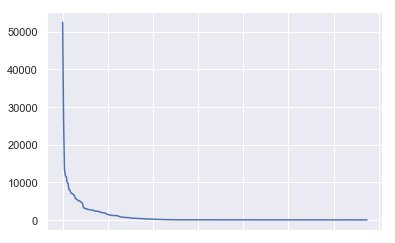

In [460]:
analyzed_df['company'].value_counts().plot()

In [466]:
# analyzed_df['company'].hist()

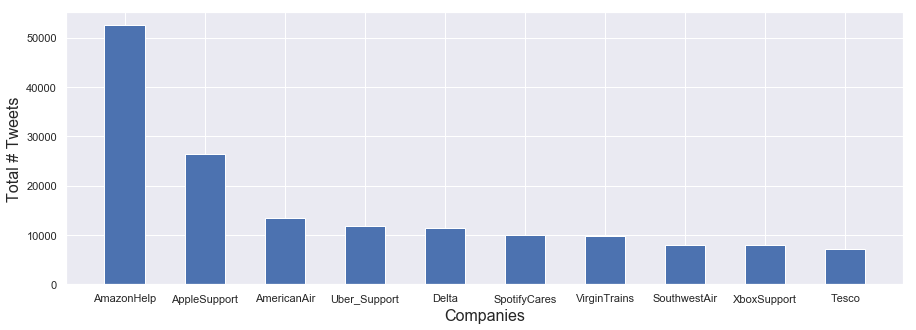

In [470]:
plt.figure(figsize=(15,5))
plt.bar(top_companies, top_counts, width=0.5)
plt.xlabel('Companies', fontsize=16)
plt.ylabel('Total # Tweets', fontsize=16)
plt.savefig('Top_mentioned_companies.png', format='png', bbox_inches='tight')

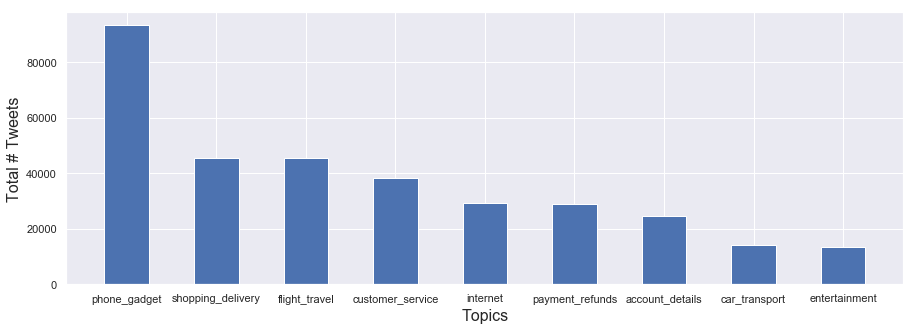

In [473]:
plt.figure(figsize=(15,5))
plt.bar(top_topics, top_counts, width=0.5)
plt.xlabel('Topics', fontsize=16)
plt.ylabel('Total # Tweets', fontsize=16)
plt.savefig('Top_mentioned_topics.png', format='png', bbox_inches='tight')

# Word Clouds

In [317]:
phone_df = analyzed_df[analyzed_df['top_topic'] == 'phone_gadget']
shopping_df = analyzed_df[analyzed_df['top_topic'] == 'shopping_delivery']
travel_df = analyzed_df[analyzed_df['top_topic'] == 'flight_travel']
cs_df = analyzed_df[analyzed_df['top_topic'] == 'customer_service']
internet_df = analyzed_df[analyzed_df['top_topic'] == 'internet']
payment_df = analyzed_df[analyzed_df['top_topic'] == 'payment_refunds']
account_df = analyzed_df[analyzed_df['top_topic'] == 'account_details']
car_df = analyzed_df[analyzed_df['top_topic'] == 'car_transport']
entertainment_df = analyzed_df[analyzed_df['top_topic'] == 'entertainment']

In [318]:
from wordcloud import WordCloud

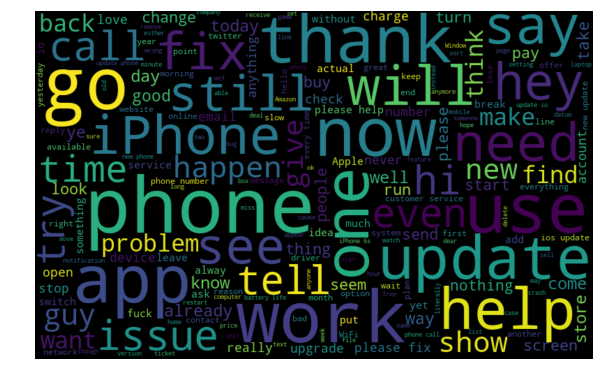

In [319]:
all_words = ' '.join([text for text in phone_df['lemma_tweets']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

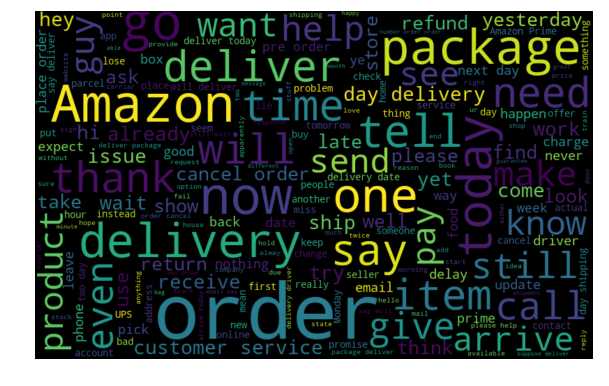

In [320]:
all_words = ' '.join([text for text in shopping_df['lemma_tweets']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

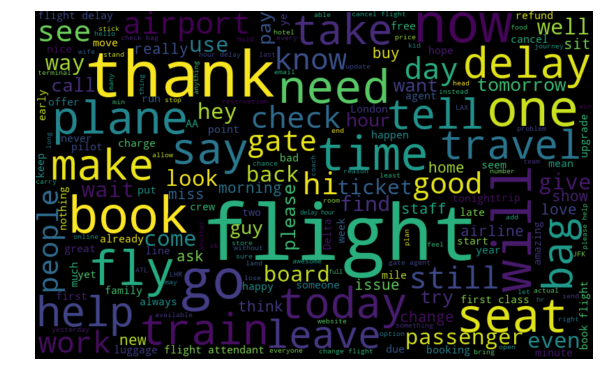

In [321]:
all_words = ' '.join([text for text in travel_df['lemma_tweets']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

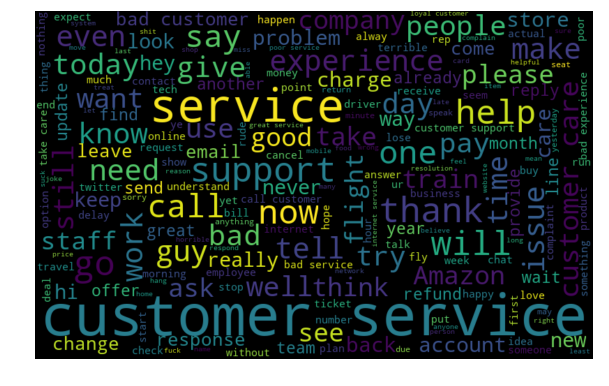

In [322]:
all_words = ' '.join([text for text in cs_df['lemma_tweets']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

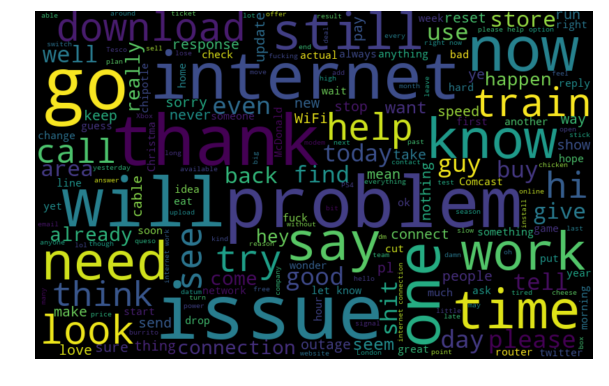

In [323]:
all_words = ' '.join([text for text in internet_df['lemma_tweets']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

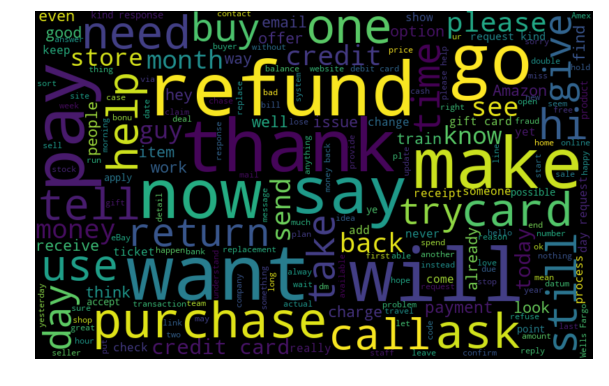

In [324]:
all_words = ' '.join([text for text in payment_df['lemma_tweets']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

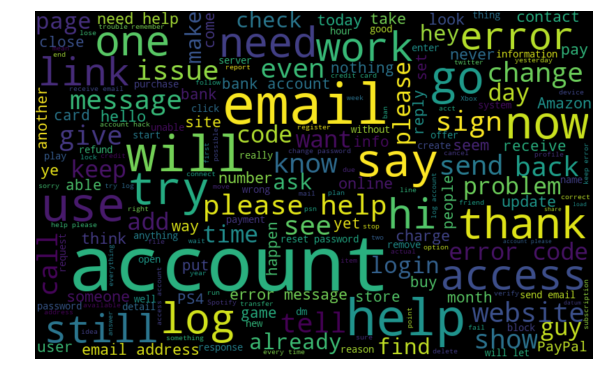

In [325]:
all_words = ' '.join([text for text in account_df['lemma_tweets']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

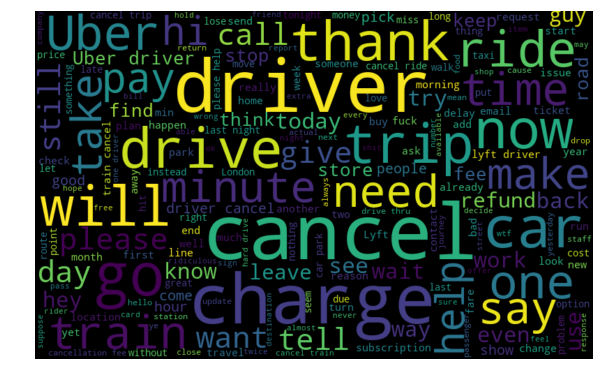

In [326]:
all_words = ' '.join([text for text in car_df['lemma_tweets']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

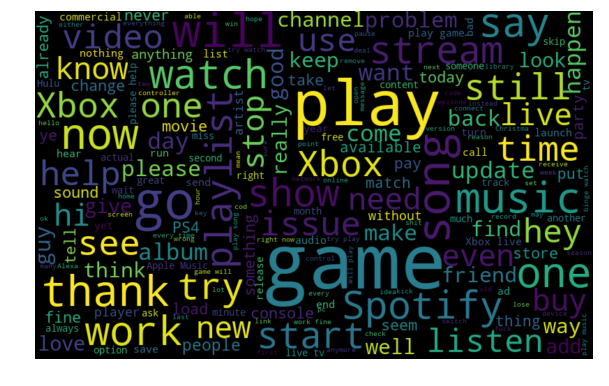

In [327]:
all_words = ' '.join([text for text in entertainment_df['lemma_tweets']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

# ScatterText

In [328]:
import spacy
import scattertext as st

nlp = spacy.load('en')

In [ ]:
corpus = st.CorpusFromPandas(convention_df,
                             category_col='party',
                             text_col='text',
                             nlp=nlp).build()

# Clustering Analysis - DBSCAN

In [347]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import sklearn.utils
from sklearn import metrics

ImportError: cannot import name 'hdbscan' from 'sklearn.cluster' (/Users/Valentina/anaconda3/lib/python3.7/site-packages/sklearn/cluster/__init__.py)

In [ ]:
['shopping_delivery_sent', 'phone_gadget_sent','customer_service_sent','flight_travel_sent','account_details_sent','internet_sent','car_transport_sent','payment_refunds_sent','deals_sent','entertainment_sent']

In [256]:
comp_grouped_df = (analyzed_df.groupby(['company'], as_index=False)
                     .agg({'shopping_delivery_sent': 'mean', 'phone_gadget_sent': 'mean', 'customer_service_sent': 'mean',
                           'flight_travel_sent': 'mean', 'account_details_sent': 'mean', 'internet_sent': 'mean',
                           'car_transport_sent': 'mean', 'payment_refunds_sent': 'mean', 'deals_sent': 'mean',
                           'entertainment_sent': 'mean'}))

In [293]:
comp_grouped_df.company.unique()

array(['applesupport', 'att', 'atviassist', 'awssupport',
       'adityabirlagrp', 'adobecare', 'airasiasupport', 'airbnbhelp',
       'alaskaair', 'aldiuk', 'amazonhelp', 'americanair', 'arbyscares',
       'argoshelpers', 'askamex', 'askciti', 'askdsc', 'askebay',
       'asklyft', 'askpapajohns', 'askpaypal', 'askplaystation', 'askrbc',
       'askrobinhood', 'askseagate', 'asktarget', 'asktigogh',
       'askvirginmoney', 'ask_spectrum', 'ask_wellsfargo', 'asurioncares',
       'azuresupport', 'bofa_help', 'boostcare', 'british_airways',
       'chipotletweets', 'carlsjr', 'centurylinkhelp', 'chasesupport',
       'comcastcares', 'coxhelp', 'dellcares', 'delta', 'doordash_help',
       'dropboxsupport', 'dunkindonuts', 'ebay', 'flyfrontier', 'glocare',
       'gwrhelp', 'godaddyhelp', 'googleplaymusic', 'greggsofficial',
       'hpsupport', 'hiltonhelp', 'hoteltonightcx', 'ihgservice',
       'jetblue', 'jackbox', 'kfc_uki_help', 'keybank_help', 'kimpton',
       'lhr', 'londonmidl

In [255]:
def clean_companies(x):
    x = str(x.lower())
    if x in (['waiting','was','who','why','with','you','your','to','top','using','so','the','thing','probably',
              'quick','rupees','screen','service','mobile' ,'more','much' ,'my' ,'night' ,'no' ,'number','on',
              'or','out','phone', 'plans','me','manojsinhabjp', 'like' ,'limited','losses','gon','gonna','help',
              'home', 'complicated', 'd', 'declining', 'do','fed', 'flight', 'floor','food','for', 'fraudulent', 
              'from','glad','glitch', 'card', 'change' ,'be','being', 'bill', 'a' ,'access','account','activating',
              'i', 'boston', 'chicago', 'after']):
        return np.nan
    else:
        if x == 'airasia':
            return 'airasiasupport'
        elif x== 'centurylink':
            return 'centurylinkhelp'
        elif x == 'chase':
            return 'chasesupport'
        elif x == 'verizon':
            return 'verizonsupport'
        elif x == 'uber':
            return 'uber_support'
        else:
            return x

In [257]:
comp_grouped_df['company'] = comp_grouped_df['company'].astype('str') 
comp_grouped_df['company'] = comp_grouped_df['company'].progress_apply(clean_companies)




  0%|          | 0/338 [00:00<?, ?it/s]


100%|██████████| 338/338 [00:00<00:00, 97488.29it/s]

In [260]:
comp_grouped_df.dropna(subset=['company'], axis=0, inplace=True)

In [261]:
X = (comp_grouped_df[['shopping_delivery_sent', 'phone_gadget_sent', 'customer_service_sent', 'flight_travel_sent', 
                      'account_details_sent', 'internet_sent', 'car_transport_sent', 'internet_sent', 
                      'payment_refunds_sent', 'entertainment_sent']])

In [33]:
# X = StandardScaler().fit_transform(smaller_X)

In [303]:
db = DBSCAN(eps=0.2, min_samples=6, metric='cosine', n_jobs = -1).fit(X)

In [304]:
labels_db = db.labels_
# labels_db

In [305]:
n_clusters_ = len(set(labels_db)) - (1 if -1 in labels_db else 0)
n_noise_ = list(labels_db).count(-1)

In [306]:
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels_db))

Estimated number of clusters: 3
Estimated number of noise points: 60
Silhouette Coefficient: 0.189


In [307]:
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

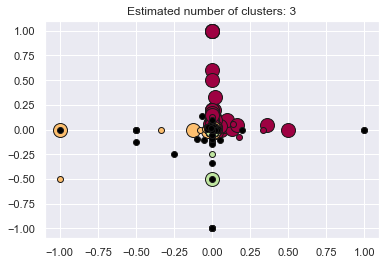

In [316]:
# Black removed and is used for noise instead.
unique_labels_db = set(labels_db)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels_db))]
for k, col in zip(unique_labels_db, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels_db == k)
    
    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy.iloc[:, 0], xy.iloc[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy.iloc[:, 0], xy.iloc[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [309]:
comp_grouped_df['cluster'] = labels_db

In [310]:
comp_grouped_df.head()

,company,shopping_delivery_sent,phone_gadget_sent,customer_service_sent,flight_travel_sent,account_details_sent,internet_sent,car_transport_sent,payment_refunds_sent,deals_sent,entertainment_sent,cluster
0,applesupport,0.000055,0.999999,0.000014,0.000030,0.000028,0.000062,0.000028,0.000052,0.000073,0.000083,0
1,att,-0.001840,0.021990,0.021960,0.002451,0.000007,-0.010976,-0.009753,0.000010,0.004295,-0.002400,0
2,atviassist,0.012185,0.026122,0.008355,-0.000339,-0.023313,0.045969,-0.000167,0.005243,0.009944,0.073352,0
3,atviassist,-0.000013,-0.000024,0.000001,-0.000025,-0.000062,-0.333334,-0.000014,-0.000016,-0.000025,-0.000172,-1
4,awssupport,-0.002377,0.023949,0.054899,0.000023,0.062088,0.016767,-0.002370,-0.009472,-0.004720,-0.002371,0


In [311]:
comp_grouped_df.to_csv('data/cs/cust_subsets/topic_clusters_by_comp.csv')

In [343]:
# from sklearn.cluster import AgglomerativeClustering

In [344]:
# AC = AgglomerativeClustering(n_clusters = , affinity='cosine', linkage='complete').fit(X)

In [ ]:
# labels_ac = AC.labels_

In [ ]:
# print('Estimated number of clusters: %d' % AC.n_clusters)
# print("Silhouette Coefficient: %0.3f"
#       % metrics.silhouette_score(X, labels_ac))

In [352]:
import hdbscan

AttributeError: type object 'hdbscan._hdbscan_linkage.UnionFind' has no attribute '__reduce_cython__'

In [345]:
hdb = HDBSCAN(min_samples=6, min_cluster_size = 5, metric='cosine', n_jobs = -1).fit(X)

NameError: name 'HDBSCAN' is not defined

In [304]:
labels_db = db.labels_
# labels_db

In [305]:
n_clusters_ = len(set(labels_db)) - (1 if -1 in labels_db else 0)
n_noise_ = list(labels_db).count(-1)

In [306]:
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels_db))

Estimated number of clusters: 3
Estimated number of noise points: 60
Silhouette Coefficient: 0.189


In [307]:
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

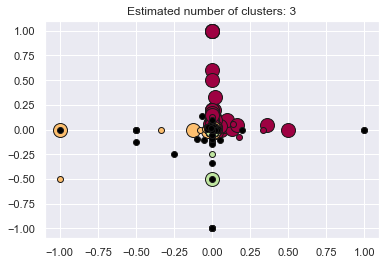

In [316]:
# Black removed and is used for noise instead.
unique_labels_db = set(labels_db)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels_db))]
for k, col in zip(unique_labels_db, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels_db == k)
    
    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy.iloc[:, 0], xy.iloc[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy.iloc[:, 0], xy.iloc[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()